In [67]:
import pandas as pd
import numpy as np
import re
import itertools
import matplotlib.pyplot as plt
import pickle
from sklearn.utils import shuffle

from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, train_test_split, cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.feature_selection import RFECV
import xgboost as xgb
from copy import deepcopy
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import seaborn as sns
import lightgbm as lgb
import gc
import shap
from copy import deepcopy

%matplotlib inline

In [2]:
def create_feature_map(name, features):
    outfile = open(name, 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    outfile.close()

In [3]:
def holdout(model, X_train, y_train, X_test, y_test, top_feats=20, perm_gain_scale = 0.5,
            plot=True, height=0.25, vsize=20, hsize=15, tsize=12, sort_by='perm'):
    
    ## calc roc auc
    y_train_pred = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict_proba(X_test)[:, 1]
    test_score, train_score = roc_auc_score(y_test, y_test_pred), roc_auc_score(y_train, y_train_pred)
    
    if plot:
        # calc importances
        perm_importances = permutation_importance(model, X_test, y_test, 
                                              scoring='roc_auc', random_state=0)['importances_mean']
        gain_importances = model.feature_importances_
    
        # get top df
        top_df = pd.DataFrame()
        top_df['names'] = X_test.columns
        top_df['perm'] = perm_importances
        top_df['gain'] = gain_importances
    
        top_df.sort_values(by=sort_by, ascending=False, inplace=True)
        top_df = top_df.iloc[:top_feats].sort_values(by=sort_by, ascending=True).reset_index(drop=True)
    
        # draw plot
        ar = np.arange(len(top_df))
        plt.figure(figsize=(vsize, hsize))
        plt.barh(ar - height, top_df.perm, height=height, label='permutation')
        plt.barh(ar + height, top_df.gain * perm_gain_scale, height=height, label='gain')
        plt.yticks(ar, top_df.names, size=tsize)
        
        plt.title('Значимость признаков для модели', size=20)
        plt.grid()
        plt.legend(loc=4, prop={'size': 20})
        plt.show()
    
    return test_score, train_score

In [68]:
def cross_validation(model, df, features, cv=3, top_feats=20, subs_train=1., subs_test=1.,
                     calc_top=True, plot=True, prnt=True, 
                     height=0.25, vsize=20, hsize=15, tsize=12, sort_by='perm'):
    
    assert cv > 0, "'cv' parameter must be > 0"
    np.random.seed(0)
    X = df.loc[df.validation == 'train', features]
    y = df.loc[df.validation == 'train', 'target']
    groups = df.loc[df.validation == 'train', 'msisdn_hash']
    X, y, groups = shuffle(X, y, groups, random_state=0)
    kf = GroupKFold(n_splits=cv)
    
    perm_importances, gain_importances = [], []
    train_scores, test_scores = [], []
    for i, (train_index, test_index) in enumerate(kf.split(X, groups=groups)):
        if prnt:
            print("Fitting on fold number", i + 1, "...")
        train_index = np.random.choice(train_index, size=int(subs_train * len(train_index)), replace=False)
        test_index = np.random.choice(test_index, size=int(subs_test * len(test_index)), replace=False)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_train_pred = model.predict_proba(X_train)[:, 1]
        y_test_pred = model.predict_proba(X_test)[:, 1]
        test_score, train_score = roc_auc_score(y_test, y_test_pred), roc_auc_score(y_train, y_train_pred)
        train_scores.append(train_score)
        test_scores.append(test_score)
        
        if calc_top:
            if prnt:
                print('Calculating importances...')
            perm_imp = np.array(permutation_importance(model, X_test, y_test, 
                                              scoring='roc_auc', random_state=0)['importances_mean'])
            gain_imp = np.array(model.feature_importances_)
            perm_importances.append(perm_imp)
            gain_importances.append(gain_imp)
    
    top_df = pd.DataFrame()
    if calc_top:
        # get top df
        top_df['names'] = X_test.columns
        top_df['perm'] = sum(perm_importances)/len(perm_importances)
        top_df['perm'] = top_df.perm/top_df.perm.sum()
        top_df['gain'] = sum(gain_importances)/len(gain_importances)
        top_df['gain'] = top_df.gain/top_df.gain.sum()
    
        top_df.sort_values(by=sort_by, ascending=False, inplace=True)
        top_df = top_df.reset_index(drop=True)
        top_df_show = top_df.iloc[:top_feats].sort_values(by=sort_by, ascending=True).reset_index(drop=True)
    
        if plot:
            # draw plot
            ar = np.arange(len(top_df_show))
            plt.figure(figsize=(vsize, hsize))
            plt.barh(ar - height, top_df_show.perm, height=height, label='permutation')
            plt.barh(ar + height, top_df_show.gain, height=height, label='gain')
            plt.yticks(ar, top_df_show.names, size=tsize)
        
            plt.title('Значимость признаков для модели', size=20)
            plt.grid()
            plt.legend(loc=4, prop={'size': 20})
            plt.show()
    
    return top_df, np.array(test_scores), np.array(train_scores)

In [81]:
def RFECV(model, df, features, n_iters=4, n_splits=3,
          min_feat_number=30, step=10, plot=True):
    
    candidates = list(features)
    best_steps = []
    for it in range(n_iters):
        print("Iteration number", it + 1, sep=' ')
        top_features, _, _ = cross_validation(model, df, candidates, cv=n_splits, 
                                        subs_train=1., calc_top=True, 
                                        plot=False, prnt=False)
        candidates = list(top_features.names.values)
        num_features_list = list(range(len(candidates), min_feat_number, -step))
        scores = []
        print("Looking for best number of features...")
        for num_features in num_features_list:
            selected_features_ = candidates[:num_features]
            
            ## cross validation
            _, cv, _ = cross_validation(model, df, selected_features_, cv=n_splits, 
                                        subs_train=1., calc_top=False, 
                                        plot=False, prnt=False)
            scores.append((num_features, cv.mean()))
            
        best_step_ = sorted(scores, key=lambda x: x[1])[-1]
        best_num_features, best_score = best_step_[0], best_step_[1]
        if  (it > 0) and (best_num_features == best_steps[-1][0]):
            break
        candidates = list(top_features.names.values[:best_num_features])
        print("Best number of features:", best_num_features, "; cv score = ", best_score)
        best_steps.append(best_step_)
        if plot:
            plt.plot([x[0] for x in scores], [x[1] for x in scores])
            plt.xlabel('num_features')
            plt.ylabel('score')
            plt.grid()
            plt.show()
        
    if plot:
        plt.title('Final plot')
        plt.plot([x[0] for x in best_steps], [x[1] for x in best_steps])
        plt.xlabel('num_features')
        plt.ylabel('score')
        plt.grid()
        plt.show()
        
    return candidates, best_steps

In [48]:
def get_validation_curve(model, df, features, param_name='max_depth', param_range=[], subs_train=1., subs_test=1.):
    params = model.get_params()
    train_scores, test_scores = [], []
    for i, p in enumerate(param_range):
        print('Step', i + 1, ', p =', p)
        params[param_name] = p
        model.set_params(**params)
        _, test_cv, train_cv = cross_validation(model, df, features, plot=False, 
                                                prnt=False, subs_train=subs_train, 
                                                subs_test=subs_test)
        train_scores.append((train_cv.mean(), train_cv.std()))
        test_scores.append((test_cv.mean(), test_cv.std()))
        
    plt.plot(param_range, [x[0] for x in train_scores], label='train', color='blue')
    plt.plot(param_range, [x[0] for x in test_scores], label='test', color='red')
    plt.fill_between(param_range, [x[0] - x[1] for x in test_scores], 
                     [x[0] + x[1] for x in test_scores], edgecolor='none', alpha=0.2)
    plt.grid()
    
    plt.xlabel(param_name)
    plt.ylabel('roc auc')
    plt.legend()
    plt.show()
    
    return test_scores


## Read data (first stage)

In [26]:
with open('../data/saved_features_xgb.fmap') as fl:
    #saved_features = fl.readlines()
    saved_features = [x[2:-3].strip('\t') for x in fl.readlines()]

In [14]:
## target
target_dict = pd.read_csv('../data/tds_pandas.csv')\
    .rename(columns={'default_flag': 'target'})
target_dict['request_date'] = target_dict.request_date.astype('datetime64')

## validation
target_dict['cnt'] = target_dict.groupby(['msisdn_hash', 'request_date']).mapping_id.rank().astype(int)
target_dict['validation'] = np.where(target_dict.cnt > 1, 'duplicates', 'train')
target_dict['validation'] = np.where(target_dict.request_date > pd.Timestamp('2019-12-10'), 'oot', 
                                     target_dict.validation)

ids = target_dict[target_dict.validation.isin(['oot', 'duplicates']) == False]\
    [['mapping_id', 'msisdn_hash']].reset_index(drop=True)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_idx, test_idx in gss.split(ids, groups=ids.msisdn_hash):
    train_ids, test_ids = ids.loc[train_idx, 'mapping_id'], ids.loc[test_idx, 'mapping_id']

target_dict['validation'] = np.where(target_dict.mapping_id.isin(train_ids), 'train', target_dict.validation)
target_dict['validation'] = np.where(target_dict.mapping_id.isin(test_ids), 'test', target_dict.validation)
target_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153763 entries, 0 to 153762
Data columns (total 9 columns):
request_year_month    153763 non-null object
request_date          153763 non-null datetime64[ns]
msisdn_hash           153763 non-null object
msisdn_cc_ndc         153763 non-null int64
target                153763 non-null int64
mapping_id            153763 non-null int64
month_number          153763 non-null int64
cnt                   153763 non-null int64
validation            153763 non-null object
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 10.6+ MB


In [21]:
target_dict.validation.value_counts(dropna=False)

train         101723
test           25417
oot            24472
duplicates      2151
Name: validation, dtype: int64

In [24]:
%%time
mlc = pd.read_csv('../data/mlc_features.csv')
print(len(mlc))
int_features = [f for f in mlc.columns if (mlc[f].dtype == np.int64)\
                and ((f.find('days_count') != -1) or (f.find('calls_count') != -1))]

float_features = [f for f in mlc.columns if (mlc[f].dtype == np.float64)\
                 and ((f.find('_per') != -1) or (f.find('trend') != -1)\
                      or (f.find('_to_') != -1) or (f.find('_TO_') != -1))]
cols_to_drop = ['target', 'mapping_id', 'default_flag', 
                'month_number'] + [f for f in mlc.columns if 'risk_scoring_' in f]
mlc_features = [f for f in int_features + float_features if f not in cols_to_drop]# and f in saved_features]

df = pd.merge(target_dict, mlc[['mapping_id', 'is_megafon'] + mlc_features], on='mapping_id')

del mlc
gc.collect()

153763
CPU times: user 5.94 s, sys: 529 ms, total: 6.46 s
Wall time: 6.46 s


In [25]:
%%time
phone_groups = pd.read_csv('../data/pg_features.csv')
print(len(phone_groups))
pg_features = [f for f in phone_groups.columns if f.startswith('selected_')]# and f in saved_features]

df = pd.merge(df, phone_groups[['mapping_id'] + pg_features], on='mapping_id')

del phone_groups
gc.collect()

153763
CPU times: user 7.32 s, sys: 817 ms, total: 8.13 s
Wall time: 8.13 s


In [26]:
%%time
cdr = pd.read_csv('../data/cdr_features.csv')
print(len(cdr))
cdr_features = [f for f in cdr.columns if f.startswith('selected_')]# and (f in saved_features)]

df = pd.merge(df, cdr[['mapping_id'] + cdr_features], on='mapping_id')

del cdr
gc.collect()

153763
CPU times: user 6.82 s, sys: 547 ms, total: 7.37 s
Wall time: 7.36 s


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153763 entries, 0 to 153762
Columns: 710 entries, request_year_month to selected_embedding_phone_category_group_days_count_d28_circle_d168_avg_10_scaled_w2v_09_top
dtypes: bool(1), datetime64[ns](1), float64(700), int64(5), object(3)
memory usage: 833.1+ MB


In [28]:
df.to_csv('../data/full_sample_total_v2.csv', index=False)

## Read data (final stage)

In [7]:
df = pd.read_csv('../data/full_sample_total.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153763 entries, 0 to 153762
Columns: 710 entries, request_year_month to selected_embedding_phone_category_group_days_count_d28_circle_d168_avg_10_scaled_w2v_09_top
dtypes: bool(1), float64(700), int64(5), object(4)
memory usage: 831.9+ MB


# Basic info

In [29]:
df.dtypes.value_counts()

float64           700
int64               5
object              3
datetime64[ns]      1
bool                1
dtype: int64

In [30]:
df['target'].value_counts()

0    130041
1     23722
Name: target, dtype: int64

In [31]:
df.is_megafon.value_counts(normalize=True)

False    0.778185
True     0.221815
Name: is_megafon, dtype: float64

# Basic preparation

In [32]:
features = [f for f in mlc_features + pg_features + cdr_features if f in df.columns]\

#features = saved_features
len(features)

700

In [33]:
create_feature_map('../data/total_features_list.fmap', features)

In [34]:
X_train, y_train = df.loc[df.validation == 'train', features], df.loc[df.validation == 'train', 'target']
X_test, y_test = df.loc[df.validation == 'test', features], df.loc[df.validation == 'test', 'target']
X_oot, y_oot = df.loc[df.validation == 'oot', features], df.loc[df.validation == 'oot', 'target']
#X_check, y_check = df.loc[df.validation == 'other', features], df.loc[df.validation == 'other', 'target']

In [35]:
X_train.shape, y_train.shape

((101723, 700), (101723,))

In [36]:
X_test.shape, y_test.shape

((25417, 700), (25417,))

In [37]:
X_oot.shape, y_oot.shape

((24472, 700), (24472,))

# Modelling

In [38]:
xgb_baseline = xgb.XGBClassifier(random_state=0, 
                                 max_depth=3,
                                 #scale_pos_weight=np.sqrt((len(df) - sum(df.target))/sum(df.target)),
                                 #min_child_weight=10,
                                 n_estimators=100, 
                                 learning_rate=0.1, 
                                 subsample=0.5, 
                                 colsample_by_tree=0.5, 
                                 reg_alpha=1.0, 
                                 reg_lambda=1.0,
                                 eval_metric='auc', 
                                 importance_type='gain')

In [39]:
lgb_baseline = lgb.LGBMClassifier(random_state=0, 
                                  num_leaves=15,
                                  max_depth=4,
                                  n_estimators=200,
                                  learning_rate=0.05,
                                  subsample=0.75,
                                  colsample_bytree=0.75,)
                                  #n_jobs=6)

### XGB top-100 selection

In [40]:
%%time
lgb_baseline.fit(X_train, y_train)
importances = list(zip(X_train.columns, 
                       lgb_baseline.feature_importances_))

importances = sorted(importances, key=lambda x: x[1], reverse=True)

CPU times: user 7min, sys: 5.47 s, total: 7min 5s
Wall time: 15.2 s


In [41]:
preselected_features_lgb = [x[0] for x in importances[:100]]
np.array(preselected_features_lgb)

array(['voice_count_in_out_notans_alltime_alldays_d28_per',
       'voice_count_in_notans_alltime_alldays_to_in_alltime_alldays_d28',
       'voice_count_in_out_notans_alltime_alldays_to_in_out_alltime_alldays_d28',
       'circle_short_msisdn_d3_absence_d4_28_to_common_msisdn_count_d28',
       'lifetime_days_count_per', 'circle_msisdn_count_d14_TO_d84',
       'selected_short_phone_group_days_count_d84_scaled_short_mfo',
       'selected_embedding_phone_category_group_calls_count_d28_scaled_w2v_70_bottom',
       'selected_embedding_phone_category_group_phones_count_d28_circle_d168_avg_10_scaled_w2v_41_bottom',
       'voice_count_in_alltime_alldays_trend168_d336',
       'subs_lifetime_days_count_circle_d168_avg_10_per',
       'subs_device_lifetime_per',
       'voice_count_out_alltime_alldays_trend28_d84_per',
       'selected_short_phone_group_phones_count_d84_scaled_short_store',
       'selected_embedding_phone_category_group_calls_count_d28_scaled_w2v_58_bottom',
       'circl

In [42]:
create_feature_map("../data/saved_features_lgb.fmap", preselected_features_lgb)

In [43]:
preselected_features = preselected_features_lgb

### Generation

In [113]:
## trends
trend_features = []
for f in [f for f in preselected_features if ('d28' in f) and (f.startswith('selected_'))]:
    if f.replace('d28', 'd84') in preselected_features:
        df[f + '_trend'] = df[f]/(1 + df[f.replace('d28', 'd84')])
        trend_features.append(f + '_trend')

In [114]:
trend_features

['selected_short_phone_group_days_count_d28_circle_d168_avg_10_scaled_short_messenger_trend',
 'selected_short_phone_group_phones_count_d28_scaled_short_store_trend',
 'selected_short_phone_group_calls_count_d28_circle_d168_avg_10_scaled_short_store_trend']

### Custom selection

In [69]:
lgb_classifier = lgb.LGBMClassifier(random_state=0, 
                                  num_leaves=15,
                                  max_depth=4,
                                  n_estimators=200,
                                  learning_rate=0.05,
                                  subsample=0.75,
                                  colsample_bytree=0.75,
                                  n_jobs=4)

In [79]:
top_features, test_scores, train_scores = cross_validation(lgb_classifier, df, preselected_features, subs_train=1.,
                                                           subs_test=1., calc_top=True, plot=False, top_feats=20)

Fitting on fold number 1 ...
Calculating importances...


KeyboardInterrupt: 

In [78]:
print("AUC on train: ", train_scores.mean(), train_scores.std())
print("AUC on val: ", test_scores.mean(), test_scores.std())

print("Gini on train: ", 2*train_scores.mean()-1, 2*train_scores.std())
print("Gini on val: ", 2*test_scores.mean()-1, 2*test_scores.std())

AUC on train:  0.7249488477448504 0.0002445203051874942
AUC on val:  0.6222668357310909 0.0017118359269083531
Gini on train:  0.4498976954897007 0.0004890406103749884
Gini on val:  0.24453367146218175 0.0034236718538167062


Iteration number 1
Looking for best number of features...
Best number of features: 75 ; cv score =  0.6250946394336239


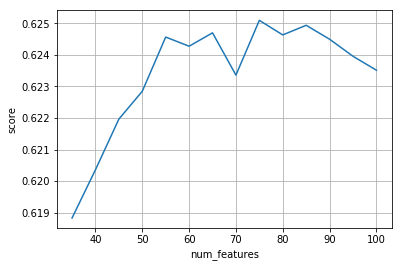

Iteration number 2
Looking for best number of features...


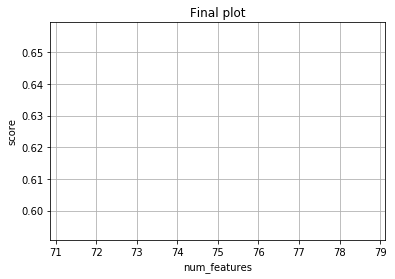

CPU times: user 49min 19s, sys: 16.9 s, total: 49min 36s
Wall time: 16min 24s


In [83]:
%%time
selected_features, best_steps = RFECV(lgb_classifier, df, preselected_features, n_splits=5,  
                                      n_iters = 2, min_feat_number=30, step=5, plot=True)

In [137]:
selected_features = [
       'voice_count_in_out_notans_alltime_alldays_d28_per',
       'voice_count_in_notans_alltime_alldays_to_in_alltime_alldays_d28',
       'voice_count_in_out_notans_alltime_alldays_to_in_out_alltime_alldays_d28',
       'circle_short_msisdn_d3_absence_d4_28_to_common_msisdn_count_d28',
       'selected_embedding_phone_category_group_phones_count_d28_circle_d168_avg_10_scaled_w2v_41_bottom',
       'subs_device_lifetime_per',
       'selected_embedding_phone_category_group_calls_count_d28_scaled_w2v_70_bottom',
       'selected_short_phone_group_days_count_d84_scaled_short_mfo',
       'circle_msisdn_count_d14_TO_d84',
       'sms_count_out_alltime_alldays_to_in_out_alltime_alldays_d84',
       'selected_embedding_phone_category_group_phones_count_d28_circle_d168_avg_10_scaled_w2v_59_top',
       'voice_sms_count_in_out_alltime_alldays_d336_per',
       'selected_short_phone_group_phones_count_d84_scaled_short_store',
       'lifetime_days_count_per',
       'selected_embedding_phone_category_group_phones_count_d28_circle_d168_avg_10_scaled_w2v_33_top',
       'selected_twogis_group_phones_count_d84_circle_d168_avg_10_scaled_bankovskie_finansovye_uslugi',
       'selected_embedding_phone_category_group_calls_count_d28_scaled_w2v_58_bottom',
       'selected_embedding_phone_category_group_phones_count_d28_scaled_w2v_55_bottom',
       'sms_count_in_alltime_alldays_to_in_out_alltime_alldays_d84',
       'selected_short_phone_group_calls_count_d84_scaled_short_megafon',
       'circle_stable_to_common_msisdn_count_d28',
       'circle_no_short_msisdn_count_d28_per',
       'circle_spam_msisdn_count_d28_per',
       'selected_short_phone_group_phones_count_d84_circle_d168_avg_10_scaled_short_mfo',
       'voice_count_out_alltime_alldays_trend168_d336',
       'lac_cell_distance_metre_FROM_alltran_count_night_alldays_max_TO_alltran_count_afternoon_workweek_max_d28',
       'voice_count_in_alltime_alldays_trend168_d336_circle_avg_10',
       'selected_short_phone_group_days_count_d84_scaled_short_socnet',
       'subs_lifetime_days_count_circle_d168_avg_10_per',
       'payment_amount_min_m12_per',
       'selected_short_phone_group_phones_count_d84_circle_d168_avg_10_scaled_short_socnet',
       'selected_short_phone_group_phones_count_d84_circle_d168_avg_10_scaled_short_delivery',
       'selected_embedding_phone_category_group_days_count_d28_scaled_w2v_95_bottom',
       'selected_twogis_group_days_count_d84_scaled_skoraa_medicinskaa_pomos',
       'circle_sms_in_msisdn_count_d28_TO_d168_circle_top_1',
       'voice_count_out_alltime_alldays_trend28_d84_per',
       'selected_embedding_phone_category_group_phones_count_d28_circle_d168_avg_10_scaled_w2v_03_top',
       'selected_short_phone_group_days_count_d84_circle_d168_avg_10_scaled_short_moneytrans',
       'voice_duration_seconds_out_alltime_alldays_d28_per',
       'payment_amount_m12_per',
       'selected_short_phone_group_phones_count_d84_scaled_short_delivery',
       'selected_embedding_phone_category_group_days_count_d28_scaled_w2v_03_bottom',
       'selected_twogis_group_phones_count_d84_circle_d168_avg_10_scaled_medicina_zdorove_krasota',
       'selected_embedding_phone_category_group_calls_count_d28_scaled_w2v_28_bottom',
       'imei_change_count_d28_per_circle_top_2',
       'voice_sms_count_in_alltime_alldays_trend28_d84',
       'selected_embedding_phone_category_group_days_count_d28_circle_d168_avg_10_scaled_w2v_55_bottom',
       'selected_embedding_phone_category_group_calls_count_d28_scaled_w2v_68_bottom',
       'voice_sms_count_out_alltime_alldays_to_in_out_alltime_alldays_d84_circle_avg_10',
       'selected_embedding_phone_category_group_calls_count_d28_scaled_w2v_33_top',
       'circle_in_msisdn_count_d14_TO_d84',
       'selected_embedding_phone_category_group_calls_count_d28_circle_d168_avg_10_scaled_w2v_36_top',
       'voice_sms_count_in_out_alltime_alldays_trend168_d336',
       'selected_embedding_phone_category_group_phones_count_d28_scaled_w2v_27_bottom',
       'selected_embedding_phone_category_group_phones_count_d28_scaled_w2v_38_bottom',
       'selected_embedding_phone_category_group_phones_count_d28_circle_d168_avg_10_scaled_w2v_54_bottom',
       #'selected_twogis_group_days_count_d84_scaled_punkty_priema_platezej_rascetnye_centry_kommunalnyh_uslug',
       'selected_embedding_phone_category_group_calls_count_d28_circle_d168_avg_10_scaled_w2v_59_bottom',
       'selected_short_phone_group_days_count_d84_circle_d168_avg_10_scaled_short_collection',
       'voice_count_in_alltime_alldays_to_out_alltime_alldays_d336',
       'selected_twogis_group_calls_count_d28_circle_d168_avg_10_scaled_specmagaziny',
       'voice_sms_count_in_alltime_alldays_to_in_out_alltime_alldays_d84_circle_avg_10',
       'voice_sms_count_in_out_alltime_alldays_trend84_d168',
       'voice_sms_count_in_alltime_alldays_trend168_d336',
       'selected_embedding_phone_category_group_calls_count_d28_scaled_w2v_38_bottom',
       'selected_twogis_group_calls_count_d84_circle_d168_avg_10_scaled_pravoohranitelnye_organy',
       'block_count_m12_circle_d168_avg_10_per',
       'selected_short_phone_group_calls_count_d7_scaled_short_tcsbank',
       'alltran_count_in_out_alltime_alldays_trend1_d28',
       'selected_embedding_phone_category_group_phones_count_d28_scaled_w2v_86_bottom',
       'selected_twogis_group_calls_count_d84_circle_d168_avg_10_scaled_lombardy',
       'voice_count_in_alltime_alldays_to_in_out_alltime_alldays_d336_per',
       'selected_twogis_group_calls_count_d84_circle_d168_avg_10_scaled_fitnes_kluby',
       'subs_lifetime_days_count_per_circle_d168_top_2',
       'selected_twogis_group_days_count_d84_circle_d168_avg_10_scaled_ustanovka_remont_avtomobilnoj_optiki'
]

In [138]:
X_train_f = df.loc[df.validation == 'train', selected_features]
X_test_f = df.loc[df.validation == 'test', selected_features]
X_oot_f = df.loc[df.validation == 'oot', selected_features]

y_train = df.loc[df.validation == 'train', 'target']
y_test = df.loc[df.validation == 'test', 'target']
y_oot = df.loc[df.validation == 'oot', 'target']
#X_check_f = df.loc[df.validation == 'other', selected_features]

In [88]:
_, test_scores, train_scores = cross_validation(lgb_classifier, df, selected_features, subs_train=1.,
                                                subs_test=1., cv=5, calc_top=False, plot=False)

print("AUC on train: ", train_scores.mean(), train_scores.std())
print("AUC on val: ", test_scores.mean(), test_scores.std())

print("Gini on train: ", 2*train_scores.mean()-1, 2*train_scores.std())
print("Gini on val: ", 2*test_scores.mean()-1, 2*test_scores.std())

Fitting on fold number 1 ...
Fitting on fold number 2 ...
Fitting on fold number 3 ...
Fitting on fold number 4 ...
Fitting on fold number 5 ...
AUC on train:  0.7071589323939629 0.0007928106593487158
AUC on val:  0.6240909010203464 0.006765335033005317
Gini on train:  0.41431786478792576 0.0015856213186974317
Gini on val:  0.24818180204069273 0.013530670066010634


In [89]:
len(set(df[df.validation == 'train'].msisdn_hash) & set(df[df.validation == 'test'].msisdn_hash))/len(df[df.validation == 'test'])

0.0

### Adversarial validation (if needed)

In [159]:
#%%time
#lgb_adversarial = lgb.LGBMClassifier(random_state=0)
#X_train_f['is_train'] = True
#X_test_f['is_train'] = False
#X_adv = pd.concat([X_train_f, X_test_f], axis=0).reset_index(drop=True)

#lgb_adversarial.fit(X_adv.drop('is_train', axis=1), X_adv.is_train)
#importances = list(zip(X_adv.drop('is_train', axis=1).columns, 
#                       lgb_adversarial.feature_importances_))
#importances = sorted(importances, key=lambda x: x[1], reverse=True)
#del X_adv
#gc.collect()

### Tuning

In [185]:
lgb_classifier = lgb.LGBMClassifier(random_state=0, 
                                  num_leaves=15,
                                  max_depth=4,
                                  n_estimators=200,
                                  learning_rate=0.05,
                                  subsample=0.75,
                                  colsample_bytree=0.75,)

Step 1 , p = 3
Step 2 , p = 5
Step 3 , p = 7
Step 4 , p = 9
Step 5 , p = 11
Step 6 , p = 13
Step 7 , p = 15


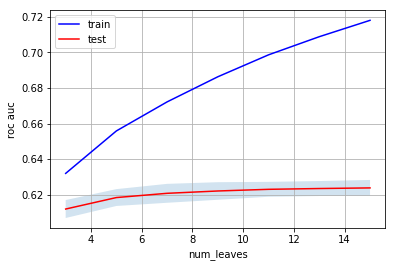

In [187]:
## num leaves
_ = get_validation_curve(deepcopy(lgb_classifier), X_train_f, y_train, 
                     param_name='num_leaves', param_range=list(range(3, 16, 2)), 
                     subs_train=1.)

Step 1 , p = 0.03
Step 2 , p = 0.06
Step 3 , p = 0.08
Step 4 , p = 0.1
Step 5 , p = 0.12


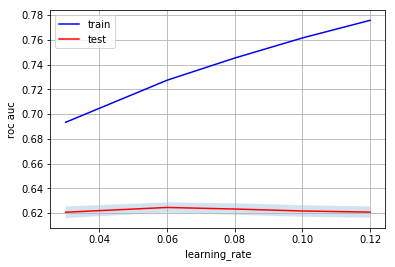

In [190]:
## learning_rate
_ = get_validation_curve(deepcopy(lgb_classifier), X_train_f, y_train, 
                     param_name='learning_rate', param_range=[0.03, 0.06, 0.08, 0.1, 0.12], 
                     subs_train=1.)

Step 1 , p = 1
Step 2 , p = 5
Step 3 , p = 10
Step 4 , p = 50
Step 5 , p = 100
Step 6 , p = 300
Step 7 , p = 500


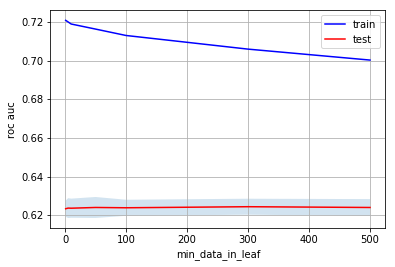

In [192]:
## min_data_in_leaf
_ = get_validation_curve(deepcopy(lgb_classifier), X_train_f, y_train, 
                     param_name='min_data_in_leaf', param_range=[1, 5, 10, 50, 100, 300, 500], 
                     subs_train=1.)

Step 1 , p = 100
Step 2 , p = 150
Step 3 , p = 200
Step 4 , p = 250
Step 5 , p = 300


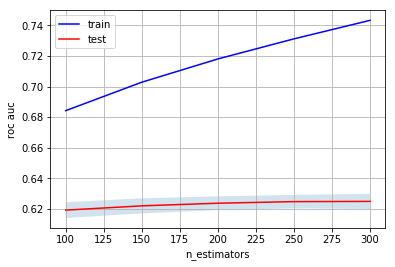

In [193]:
_ = get_validation_curve(deepcopy(lgb_classifier), X_train_f, y_train, 
                     param_name='n_estimators', param_range=[100, 150, 200, 250, 300], 
                     subs_train=1.)

In [96]:
%%time

## random search
params_grid = {
    'num_leaves': [14, 15, 16],
    'learning_rate': [0.04, 0.05, 0.06],
    'n_estimators': [225, 250, 275, 300],
    'min_child_weight': [1, 10, 50, 100, 300, 500],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9]
}

searcher = RandomizedSearchCV(lgb_classifier, params_grid, cv=5, 
                              n_iter=300, scoring='roc_auc', verbose=1, 
                              n_jobs=8, random_state=42)

searcher.fit(X_train_f, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   25.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.8min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  4.2min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:  7.5min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed: 11.7min
[Parallel(n_jobs=8)]: Done 1500 out of 1500 | elapsed: 14.0min finished


CPU times: user 29.2 s, sys: 3.7 s, total: 32.9 s
Wall time: 14min 3s


In [97]:
searcher.best_params_

{'subsample': 0.9,
 'num_leaves': 16,
 'n_estimators': 300,
 'min_child_weight': 1,
 'learning_rate': 0.05,
 'colsample_bytree': 0.5}

In [154]:
## final params
lgb_classifier = lgb.LGBMClassifier(random_state=0, 
                                  num_leaves=16,
                                  max_depth=4,
                                  min_data_in_leaf=10,
                                  n_estimators=260,
                                  learning_rate=0.04,
                                  subsample=0.9,
                                  colsample_bytree=0.5, 
                                  n_jobs=4)

In [140]:
_, test_scores, train_scores = cross_validation(lgb_classifier, df, selected_features, subs_train=1.,
                                                subs_test=1., cv=5, calc_top=False, plot=False)

print("AUC on train: ", train_scores.mean(), train_scores.std())
print("AUC on val: ", test_scores.mean(), test_scores.std())

print("Gini on train: ", 2*train_scores.mean()-1, 2*train_scores.std())
print("Gini on val: ", 2*test_scores.mean()-1, 2*test_scores.std())

Fitting on fold number 1 ...
Fitting on fold number 2 ...
Fitting on fold number 3 ...
Fitting on fold number 4 ...
Fitting on fold number 5 ...
AUC on train:  0.7107822474953126 0.0008292557054879243
AUC on val:  0.6257030329982943 0.008069986971199572
Gini on train:  0.4215644949906252 0.0016585114109758485
Gini on val:  0.25140606599658866 0.016139973942399143


# Evaluation

In [141]:
len(X_train_f.columns)

74

In [155]:
%%time
lgb_classifier.fit(X_train_f, y_train, 
                   eval_set=[(X_train_f, y_train), (X_test_f, y_test)],
                   eval_metric='auc',
                   verbose=10,
                   early_stopping_rounds=30)

Training until validation scores don't improve for 30 rounds.
[10]	training's binary_logloss: 0.427254	training's auc: 0.617677	valid_1's binary_logloss: 0.431333	valid_1's auc: 0.600687
[20]	training's binary_logloss: 0.424687	training's auc: 0.624626	valid_1's binary_logloss: 0.4294	valid_1's auc: 0.603734
[30]	training's binary_logloss: 0.422526	training's auc: 0.630766	valid_1's binary_logloss: 0.427961	valid_1's auc: 0.606332
[40]	training's binary_logloss: 0.420845	training's auc: 0.635288	valid_1's binary_logloss: 0.42692	valid_1's auc: 0.608428
[50]	training's binary_logloss: 0.419438	training's auc: 0.63974	valid_1's binary_logloss: 0.426237	valid_1's auc: 0.608787
[60]	training's binary_logloss: 0.418173	training's auc: 0.644268	valid_1's binary_logloss: 0.425673	valid_1's auc: 0.610143
[70]	training's binary_logloss: 0.417014	training's auc: 0.648508	valid_1's binary_logloss: 0.425243	valid_1's auc: 0.611022
[80]	training's binary_logloss: 0.415918	training's auc: 0.652976	v

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.04, max_depth=4,
               min_data_in_leaf=10, n_estimators=260, n_jobs=4, num_leaves=16,
               random_state=0, subsample=0.9)

In [156]:
test_score, train_score = holdout(lgb_classifier, X_train_f, y_train, X_test_f, y_test, 
                                  plot=False, top_feats=25, vsize=12)

In [157]:
print("Auc on train: ", train_score)
print("Auc on test: ", test_score)

print("Gini on train: ", 2*train_score - 1)
print("Gini on test: ", 2*test_score - 1)

Auc on train:  0.6979789170411121
Auc on test:  0.6164139868946774
Gini on train:  0.3959578340822243
Gini on test:  0.23282797378935483


In [145]:
#print("Gini on oot: ", 2*roc_auc_score(y_oot, lgb_classifier.predict_proba(X_oot_f)[:, 1]) - 1)

# Save model

In [146]:
model_name = 'model_no_bias'

In [147]:
#pickle.dump(xgb_classifier, open("../results_model/" + model_name + ".pickle.dat", "wb"))

In [148]:
lgb_classifier._Booster.save_model("../results_model/" + model_name + ".model")

In [149]:
create_feature_map("../results_model/featmap_" + model_name, X_train_f.columns)

In [150]:
from sklearn2pmml import sklearn2pmml
from sklearn2pmml import PMMLPipeline

ppl2 = PMMLPipeline([("clf", lgb_classifier)])
ppl2.target_field = "target"
ppl2.active_fields = np.array(selected_features)
sklearn2pmml(ppl2, "../results_model/" + model_name + ".pmml", with_repr = True)

/usr/local/lib64/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


# Score all objects

In [158]:
import copy
lgb_copy = copy.deepcopy(lgb_classifier)

In [159]:
%%time
groups = df.loc[df.validation == 'train', 'msisdn_hash']
df_train_pred = pd.DataFrame(cross_val_predict(lgb_copy, X_train_f, y_train, groups=groups,
                                               cv=GroupKFold(n_splits=4), method='predict_proba')[:, 1],
                             index=X_train_f.index, columns=['score'])
df_test_pred = pd.DataFrame(lgb_classifier.predict_proba(X_test_f)[:, 1], 
                            index=X_test_f.index, columns=['score'])
df_oot_pred = pd.DataFrame(lgb_classifier.predict_proba(X_oot_f)[:, 1], 
                           index=X_oot_f.index, columns=['score'])

#df_check_pred = pd.DataFrame(lgb_classifier.predict_proba(X_check_f)[:, 1], 
#                            index=X_check_f.index, columns=['score'])

df_train_pred['validation'] = 'train'
df_test_pred['validation'] = 'test'
df_oot_pred['validation'] = 'oot'
#df_check_pred['validation'] = 'other'

df_pred = pd.concat([df_train_pred, df_test_pred, df_oot_pred], axis=0)
print('OK')

OK
CPU times: user 35.7 s, sys: 334 ms, total: 36.1 s
Wall time: 10.4 s


In [160]:
columns = ['msisdn_hash', 'request_date', 'is_megafon', 'month_number', 
           'mapping_id', 'target']
df_final = df[columns].merge(df_pred, how='left', left_index=True, right_index=True)
df_final['request_ym'] = df_final.request_date.astype('datetime64[M]')
df_final['request_date'] = pd.to_datetime(df_final.request_date).dt.date.astype(str)
df_final.validation = df_final.validation.fillna('duplicates')
df_final.head()

,msisdn_hash,request_date,is_megafon,month_number,mapping_id,target,score,validation,request_ym
0,EIurW4RsvQQ=,2019-07-01,False,1,1906706,0,0.123733,train,2019-07-01
1,J6nHvFFIeEc=,2019-07-01,False,1,1907531,0,0.154637,train,2019-07-01
2,KtqZIEK91/M=,2019-07-01,False,1,1905348,0,0.135465,test,2019-07-01
3,nEGPbVJqNcc=,2019-07-01,False,1,1906755,0,0.098385,train,2019-07-01
4,/bzwOH6UCFo=,2019-07-01,False,1,1905333,0,0.162888,train,2019-07-01


In [161]:
duplicates = pd.merge(df_final[df_final.validation == 'duplicates'][['mapping_id', 'msisdn_hash', 'request_date']],
                      df_final[df_final.validation != 'duplicates'][['msisdn_hash', 'request_date', 'score']],
                      on = ['msisdn_hash', 'request_date'])

duplicates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2151 entries, 0 to 2150
Data columns (total 4 columns):
mapping_id      2151 non-null int64
msisdn_hash     2151 non-null object
request_date    2151 non-null object
score           2151 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 84.0+ KB


In [162]:
duplicate_ids = set(duplicates.mapping_id)

In [168]:
df_final_v2 = df_final.merge(duplicates[['mapping_id', 'score']].rename(columns={'score': 'dup_score'}), 
                          on='mapping_id', how='left')
df_final_v2['score'] = np.where(df_final_v2.mapping_id.isin(duplicate_ids), 
                                df_final_v2.dup_score, df_final_v2.score)

In [169]:
2*roc_auc_score(df_final_v2[df_final_v2.validation != 'duplicates'].target, 
                df_final_v2[df_final_v2.validation != 'duplicates'].score) - 1

0.24506600019219804

In [171]:
df_final_v2.to_csv('../data/df_final_no_bias.csv', index=False)

In [170]:
df_final_v2[['mapping_id', 'validation', 'score', 'target']]\
    .to_csv('../data/scored_sample_no_bias.csv', index=False)

# Model quality

### Gini

In [166]:
gini_array = []

for val in ['train', 'test', 'oot', 'all']:
    if val == 'all':
        df_slice = df_final[df_final.validation != 'duplicates']
    elif val == 'other':
        df_final[(df_final.validation == val) & (df_final.target.isna() == False)]
    else:
        df_slice = df_final[(df_final.validation == val) & (df_final.target.isna() == False)]
    df_slice_mf = df_slice[df_slice.is_megafon]
    df_slice_nmf = df_slice[~df_slice.is_megafon]
    
    ## gini
    gini = 2*roc_auc_score(df_slice.target, df_slice.score) - 1
    #gini_old = 2*roc_auc_score(df_slice.target, df_slice.old_score.fillna(0)) - 1
    
    gini_mf = 2*roc_auc_score(df_slice_mf.target, df_slice_mf.score) - 1
    #gini_old_mf = 2*roc_auc_score(df_slice_mf.target, df_slice_mf.old_score.fillna(0)) - 1
    gini_nmf = 2*roc_auc_score(df_slice_nmf.target, df_slice_nmf.score) - 1
    #gini_old_nmf = 2*roc_auc_score(df_slice_nmf.target, df_slice_nmf.old_score.fillna(0)) - 1
    
    gini_array.append([gini, gini_mf, gini_nmf])#([gini, gini_old, gini_mf, gini_old_mf, gini_nmf, gini_old_nmf])

gini_array = pd.DataFrame(np.array(gini_array), index=['train', 'test', 'oot', 'all'], 
                          columns=['gini', 'gini_mf', 'gini_nmf'])#['gini', 'gini_old', 'gini_mf', 'gini_old_mf', 'gini_nmf', 'gini_old_nmf'])

gini_array

,gini,gini_mf,gini_nmf
train,0.247928,0.342172,0.217602
test,0.232828,0.301093,0.211005
oot,0.245359,0.349256,0.213099
all,0.245066,0.336070,0.216029


### Score distribution by months

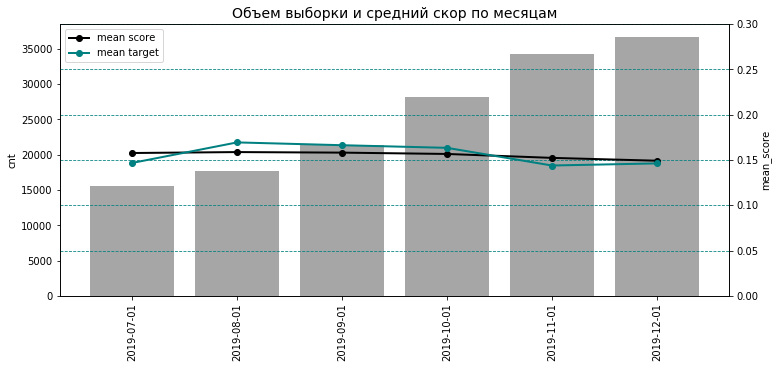

In [172]:
score_agg = df_final.groupby(['request_ym']).score.agg([np.mean, len])
target_agg = df_final[df_final.validation != 'other'].groupby(['request_ym']).target.agg([np.mean, len])
fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(score_agg.index.astype('str'), score_agg['len'], color='gray', alpha=0.7)
ax.set(ylabel='cnt')
plt.xticks(rotation=90)

#ax.axvline(x=11.5, color='k', linestyle='--', alpha=0.9)
#ax.text(8, 130500, 'TRAIN/TEST', fontsize=12, bbox=dict(facecolor='w', alpha=1))
#ax.text(14, 130500, 'OOT/CHECK', fontsize=12, bbox=dict(facecolor='w', alpha=1))

ax2 = ax.twinx()
ax2.plot(score_agg.index.astype('str'), score_agg['mean'], color='black', marker='o', lw=2, label='mean score')
ax2.plot(target_agg.index.astype('str'), target_agg['mean'], color='teal', marker='o', lw=2, label='mean target')
ax2.set(ylim=(0, 0.3), ylabel='mean_score')

ax2.grid(True,axis='both', color='teal', linestyle='--')
plt.legend(loc='upper left')
plt.title('Объем выборки и средний скор по месяцам', size=14)
plt.show()

### Gini distribution

In [173]:
df_final_ = pd.read_csv('../data/df_final_no_bias.csv')

In [174]:
gini_months = []
for m in range(1, 7):
    target = df_final_.loc[df_final_.month_number == m, 'target'].values
    score = df_final_.loc[df_final_.month_number == m, 'score'].values
    #old_score = df_final_.loc[df_final_.month_number == m, 'old_score'].values
    gini_months.append([m, 2*roc_auc_score(target, score) - 1])#, 2*roc_auc_score(target, old_score) - 1]) 
    
gini_months = pd.DataFrame(gini_months, columns=['month_number', 'gini'])#, 'old_gini'])

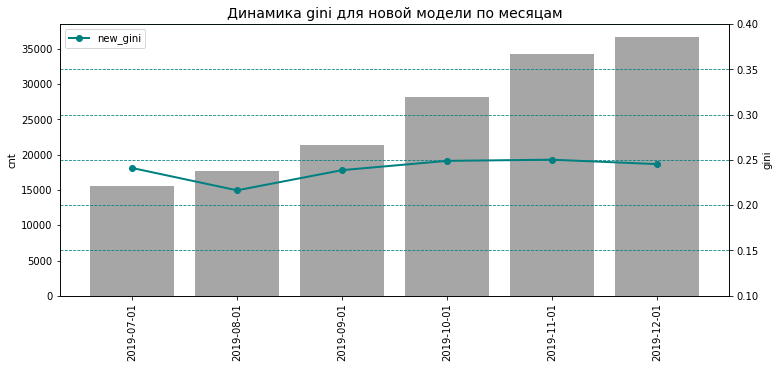

In [175]:
a = pd.merge(df_final_, gini_months, on='month_number', 
             how='left').groupby(['request_ym']).gini.agg([np.mean, len])

#b = pd.merge(df_final_, gini_months, on='month_number', 
#             how='left').groupby(['request_ym']).old_gini.agg([np.mean, len])

fig, ax = plt.subplots(figsize=(12, 5))

ax.bar(a.index.astype('str'), a['len'], color='gray', alpha=0.7)
ax.set(ylabel='cnt')
plt.xticks(rotation=90)

#ax.axvline(x=11.5, color='k', linestyle='--', alpha=0.9)
#ax.text(9, 50500, 'TRAIN/TEST', fontsize=12, bbox=dict(facecolor='w', alpha=1))
#ax.text(12, 50500, 'OOT', fontsize=12, bbox=dict(facecolor='w', alpha=1))

ax2 = ax.twinx()
ax2.plot(a.index.astype('str'), a['mean'], color='teal', 
         marker='o', lw=2, label='new_gini')
#ax2.plot(b.index.astype('str'), b['mean'], color='black', 
#         marker='o', lw=2, label='old_gini')

ax2.set(ylim=(0.1, 0.4), ylabel='gini')

ax2.grid(True, axis='both', color='teal', linestyle='--')
plt.legend(loc='upper left')
plt.title('Динамика gini для новой модели по месяцам', size=14)
plt.show()

# Model structure

### Parameters

In [176]:
lgb_classifier

LGBMClassifier(colsample_bytree=0.5, learning_rate=0.04, max_depth=4,
               min_data_in_leaf=10, n_estimators=260, n_jobs=4, num_leaves=16,
               random_state=0, subsample=0.9)

### Importances

In [177]:
feat_imp = pd.DataFrame(lgb_classifier.feature_importances_,
                        columns=['feat_imp'], index=X_train_f.columns).sort_values(by='feat_imp', ascending=False)

feat_imp.to_csv('../results_model/feat_imp_' + model_name + '.csv')
feat_imp = pd.read_csv('../results_model/feat_imp_' + model_name + '.csv', index_col=0)
feat_imp[:30]

,feat_imp
voice_count_in_out_notans_alltime_alldays_d28_per,190
voice_count_in_notans_alltime_alldays_to_in_alltime_alldays_d28,122
selected_embedding_phone_category_group_phones_count_d28_circle_d168_avg_10_scaled_w2v_41_bottom,96
voice_count_in_out_notans_alltime_alldays_to_in_out_alltime_alldays_d28,95
lifetime_days_count_per,87
circle_short_msisdn_d3_absence_d4_28_to_common_msisdn_count_d28,74
selected_embedding_phone_category_group_phones_count_d28_circle_d168_avg_10_scaled_w2v_59_top,73
block_count_m12_circle_d168_avg_10_per,72
subs_lifetime_days_count_circle_d168_avg_10_per,71
selected_embedding_phone_category_group_days_count_d28_circle_d168_avg_10_scaled_w2v_55_bottom,69


In [178]:
len(feat_imp)

74

### Shap

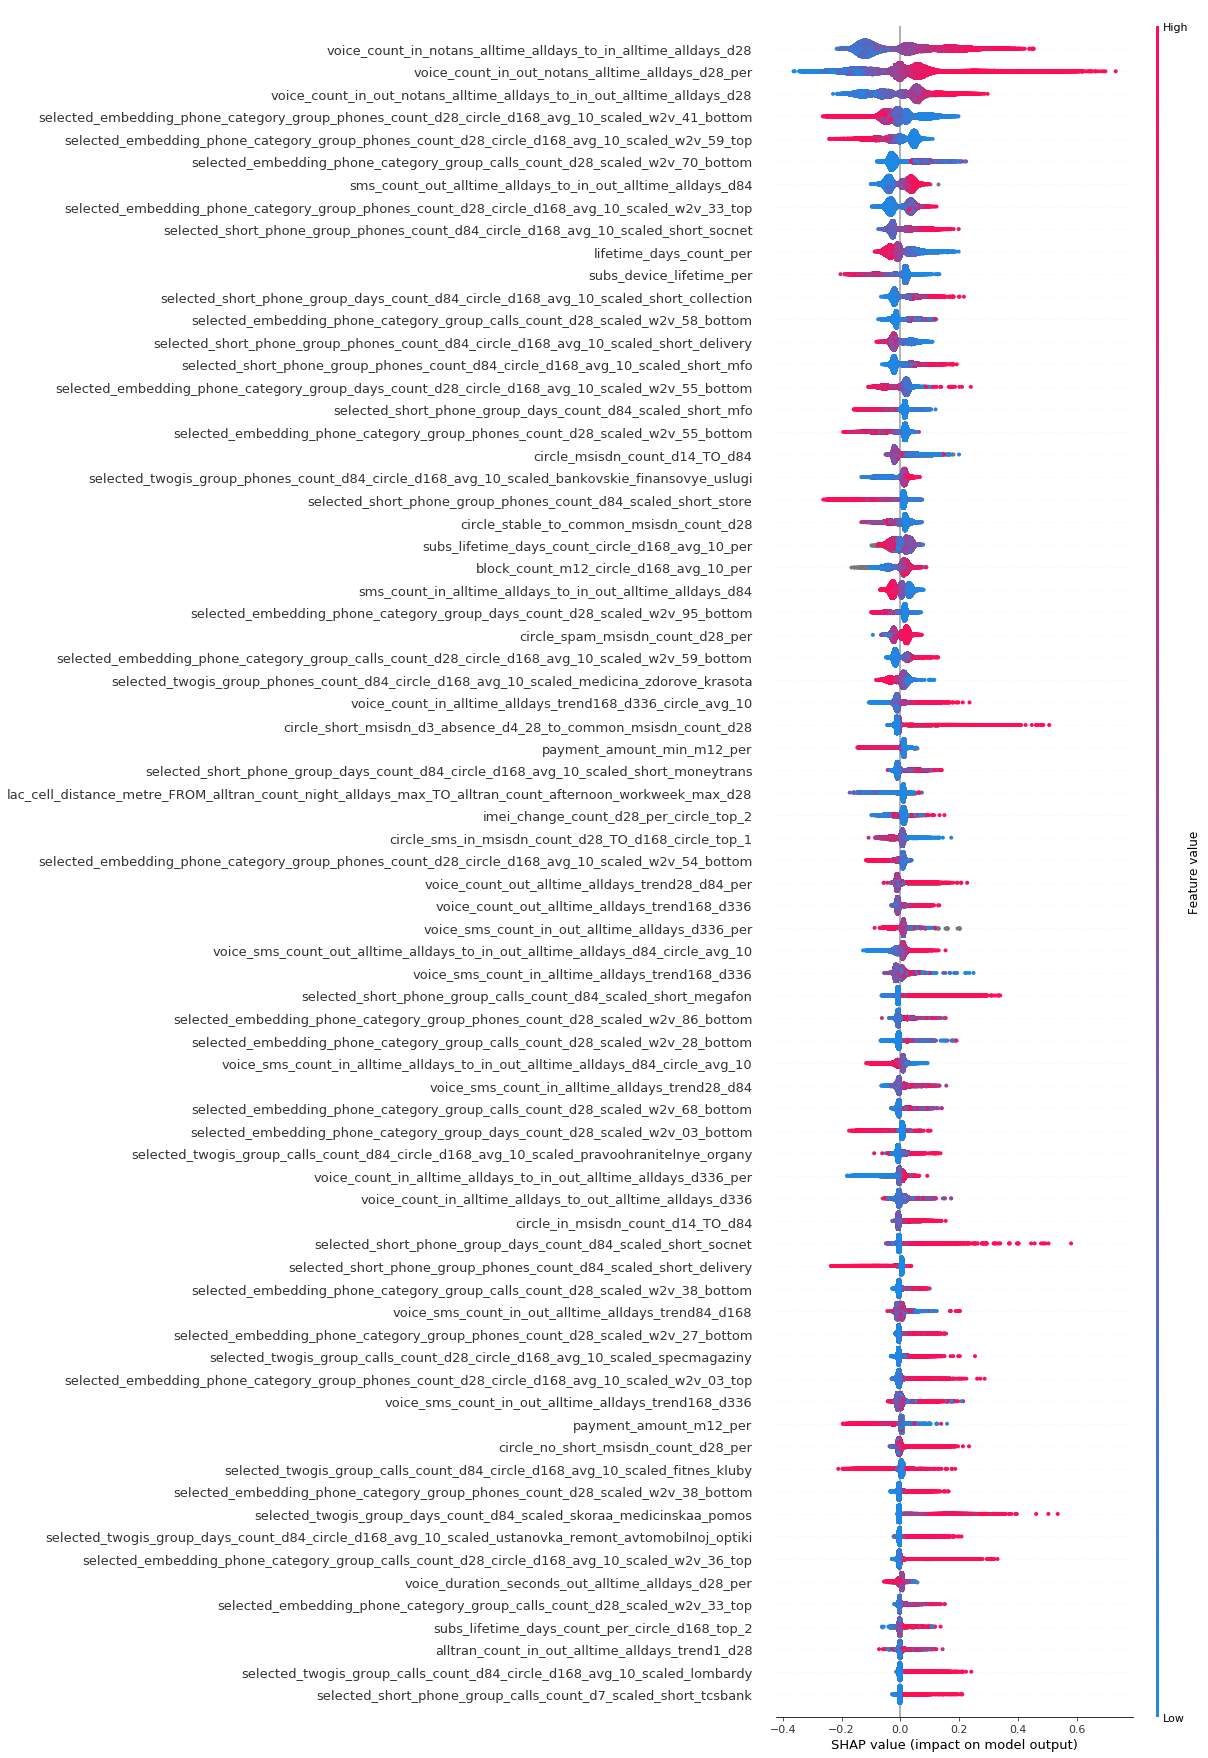

In [179]:
shap_test = shap.TreeExplainer(lgb_classifier).shap_values(X_train_f)
shap.summary_plot(shap_test, X_train_f,
                     max_display=100)

### Features distribution

In [117]:
features_to_show = selected_features[:30]

voice_count_in_out_notans_alltime_alldays_d28_per


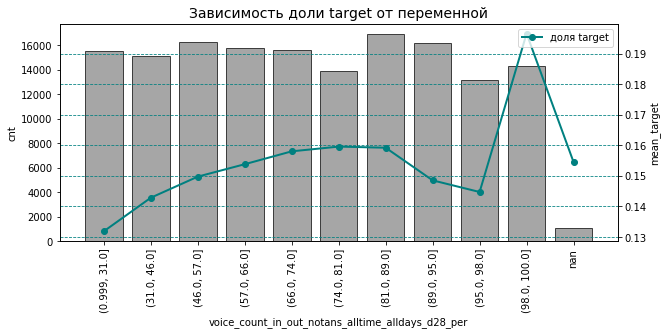

voice_count_in_notans_alltime_alldays_to_in_alltime_alldays_d28


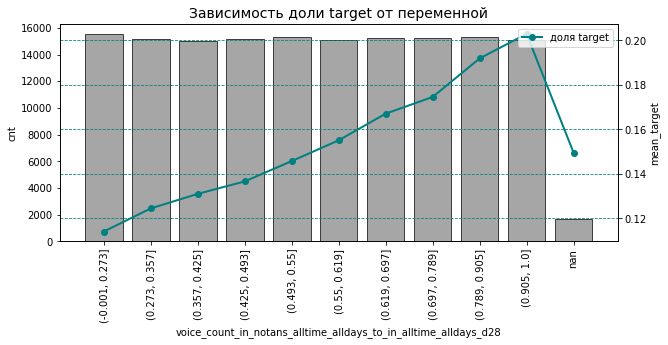

voice_count_in_out_notans_alltime_alldays_to_in_out_alltime_alldays_d28


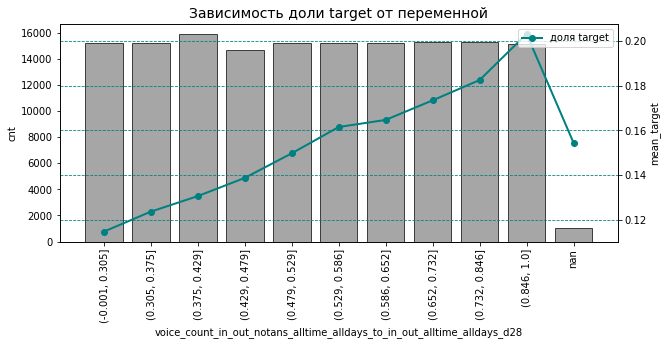

selected_embedding_phone_category_group_calls_count_d28_scaled_w2v_70_bottom


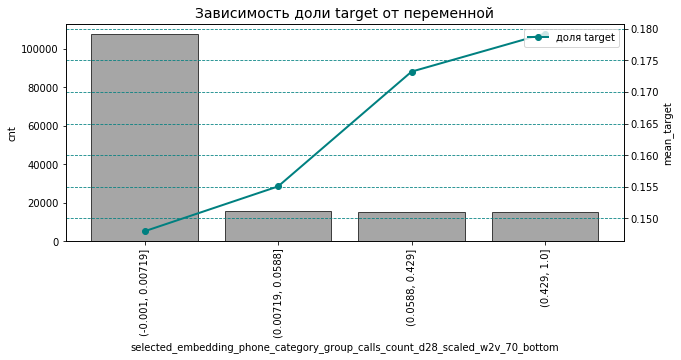

lifetime_days_count_per


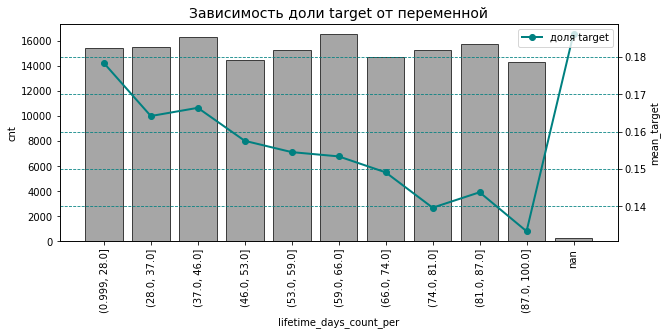

selected_short_phone_group_days_count_d84_scaled_short_mfo


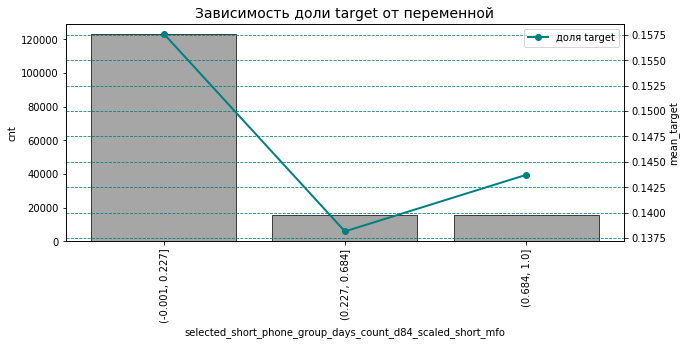

selected_embedding_phone_category_group_phones_count_d28_circle_d168_avg_10_scaled_w2v_59_top


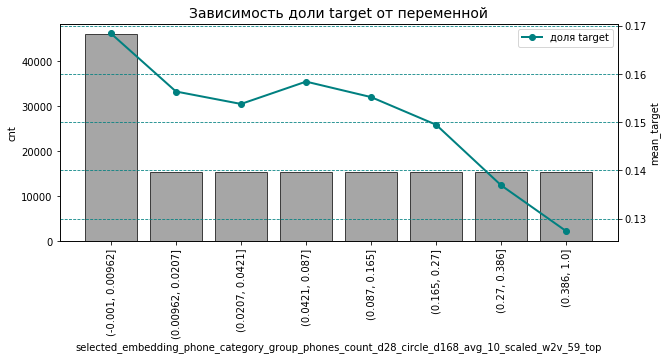

circle_spam_msisdn_count_d28_per


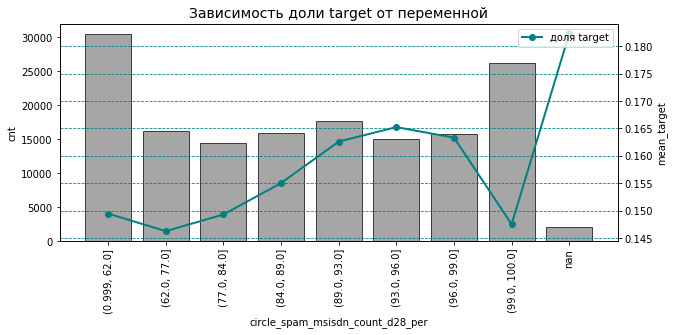

subs_device_lifetime_per


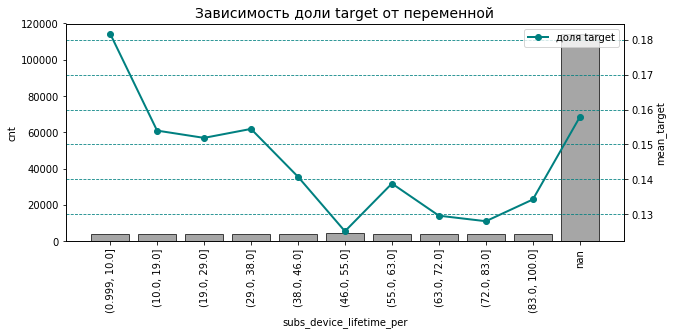

circle_msisdn_count_d14_TO_d84


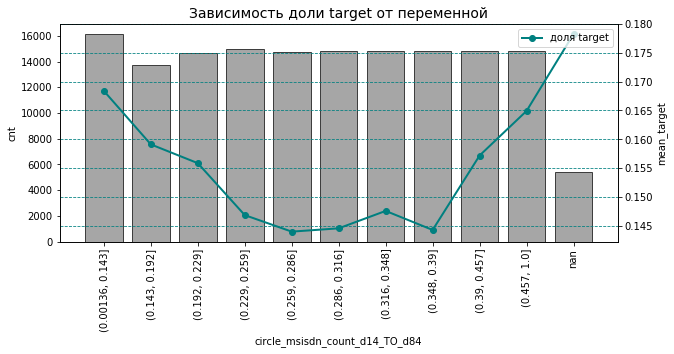

circle_short_msisdn_d3_absence_d4_28_to_common_msisdn_count_d28


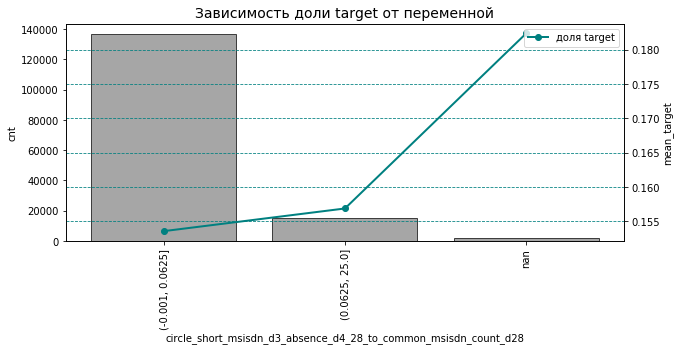

sms_count_out_alltime_alldays_to_in_out_alltime_alldays_d84


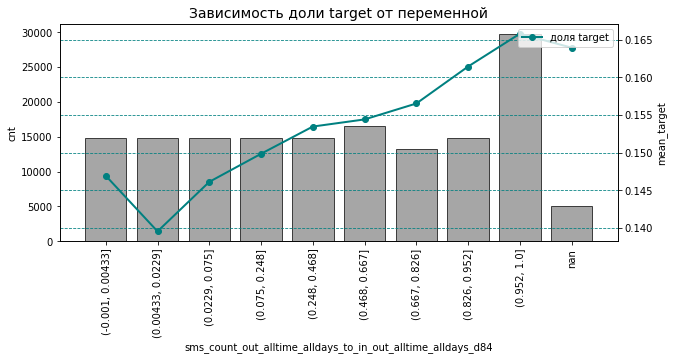

selected_embedding_phone_category_group_phones_count_d28_circle_d168_avg_10_scaled_w2v_33_top


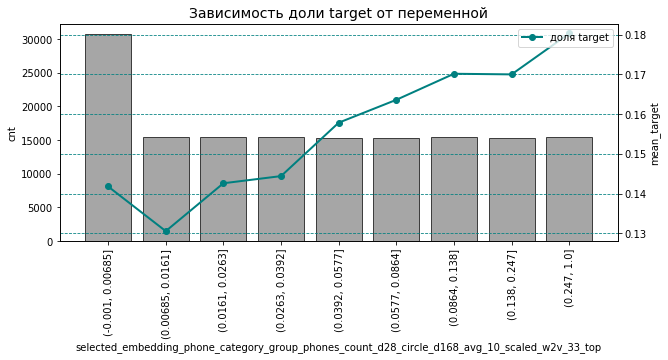

selected_twogis_group_phones_count_d84_circle_d168_avg_10_scaled_bankovskie_finansovye_uslugi


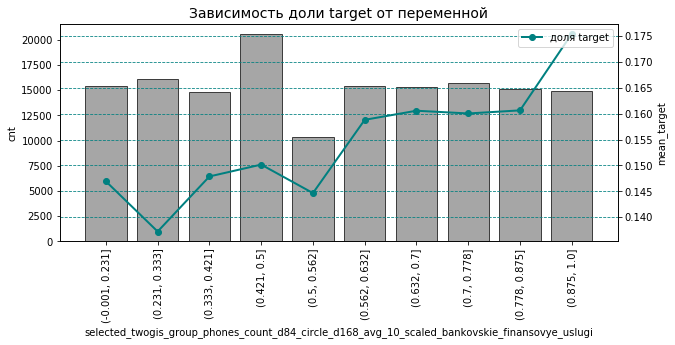

selected_short_phone_group_phones_count_d84_scaled_short_store


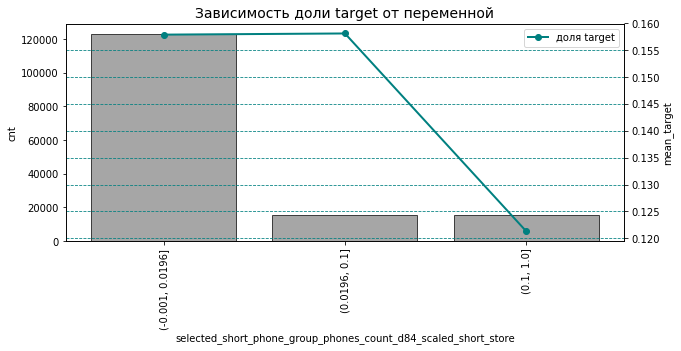

selected_embedding_phone_category_group_days_count_d28_circle_d168_avg_10_scaled_w2v_40_top


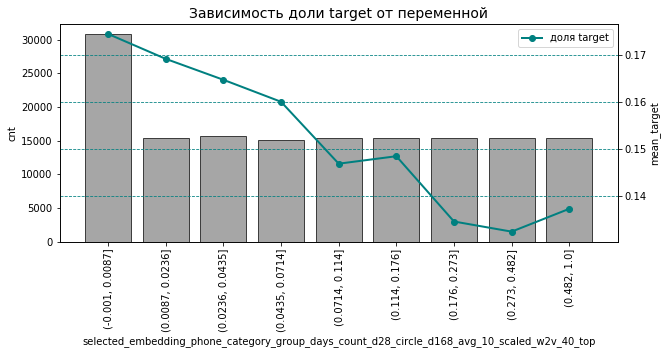

selected_embedding_phone_category_group_phones_count_d28_scaled_w2v_57_bottom


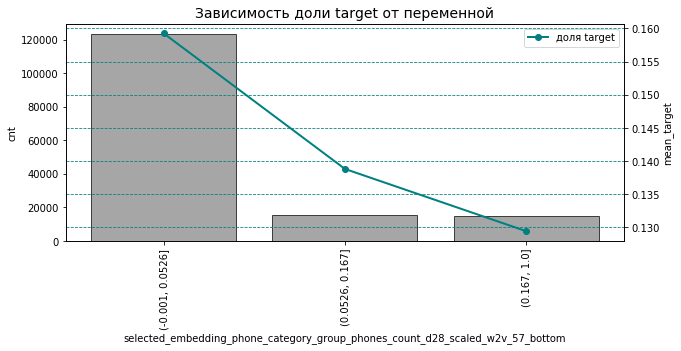

voice_sms_count_out_alltime_alldays_to_in_out_alltime_alldays_d84_circle_avg_10


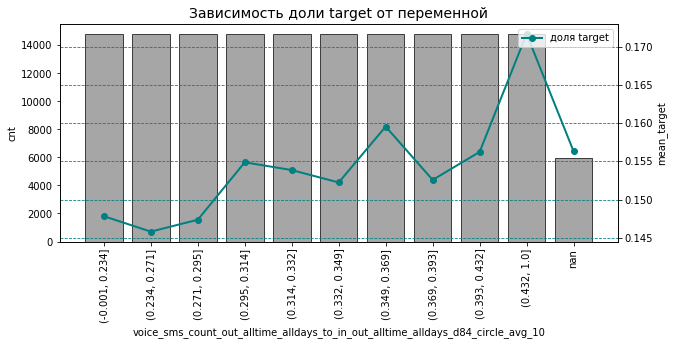

selected_short_phone_group_phones_count_d84_circle_d168_avg_10_scaled_short_store


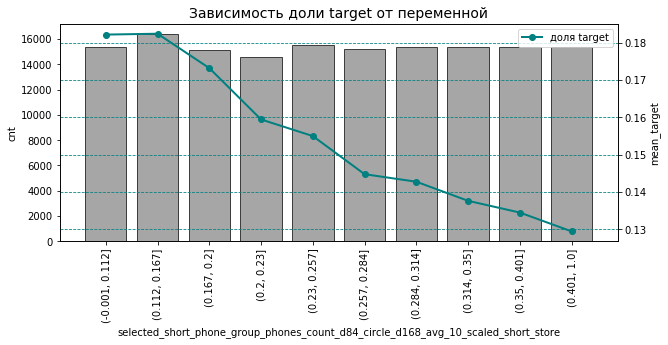

circle_short_msisdn_count_d28_per_circle_top_2


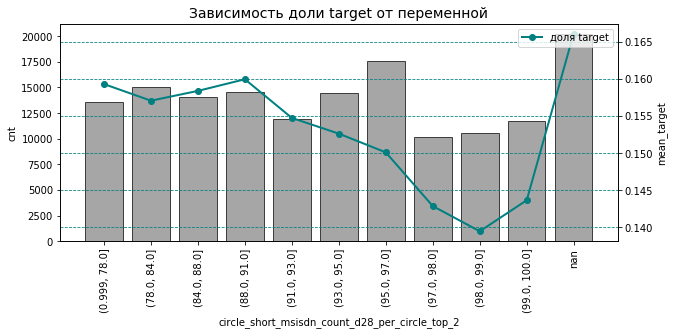

selected_short_phone_group_calls_count_d84_scaled_short_socnet


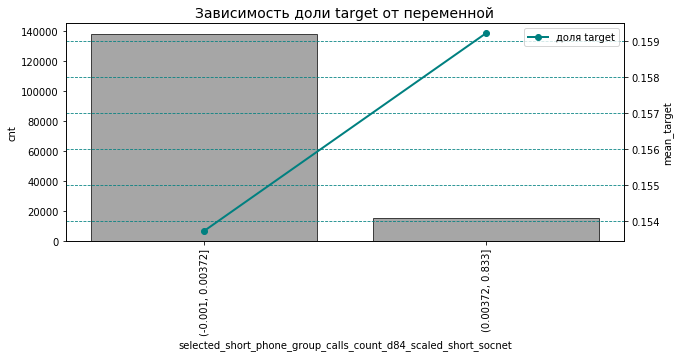

selected_embedding_phone_category_group_phones_count_d28_scaled_w2v_55_bottom


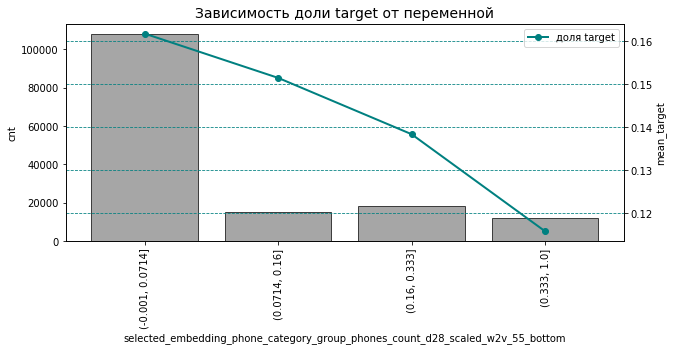

voice_count_in_alltime_alldays_trend168_d336_circle_avg_10


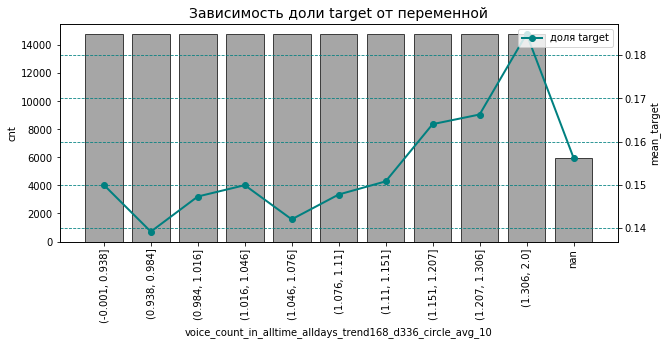

selected_embedding_phone_category_group_phones_count_d28_scaled_w2v_27_bottom


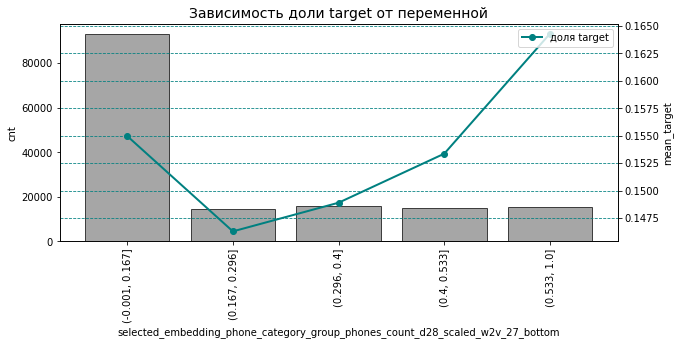

circle_stable_to_common_msisdn_count_d28


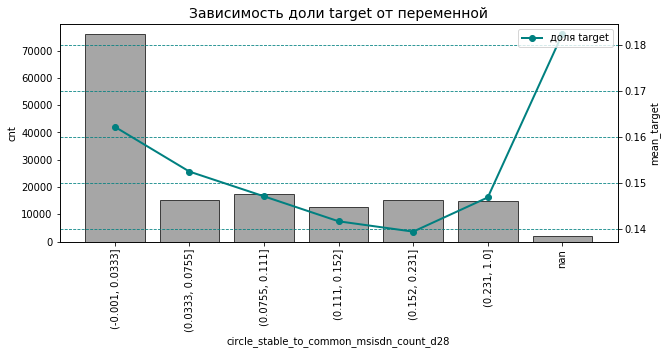

selected_twogis_group_days_count_d84_scaled_punkty_priema_platezej_rascetnye_centry_kommunalnyh_uslug


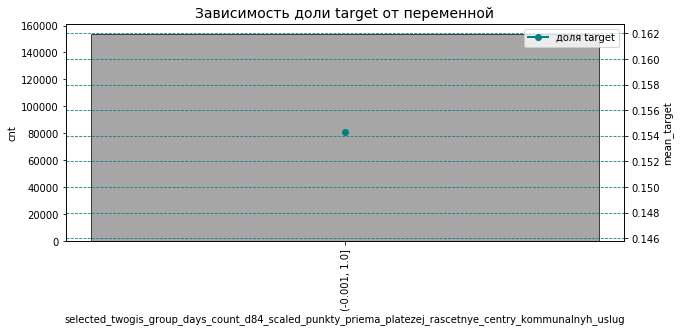

subs_lifetime_days_count_circle_d168_avg_10_per


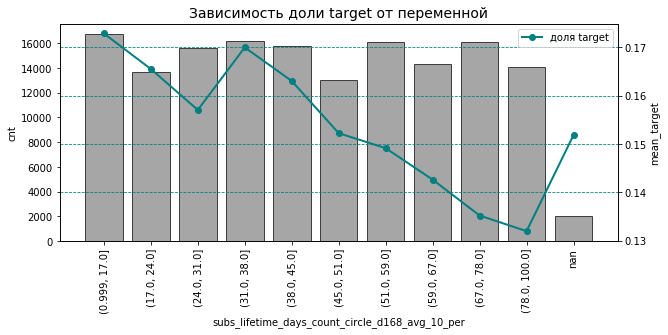

selected_short_phone_group_days_count_d84_circle_d168_avg_10_scaled_short_collection


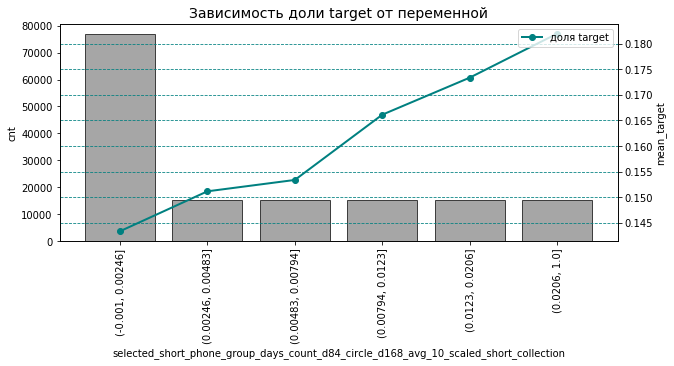

selected_embedding_phone_category_group_calls_count_d28_circle_d168_avg_10_scaled_w2v_59_bottom


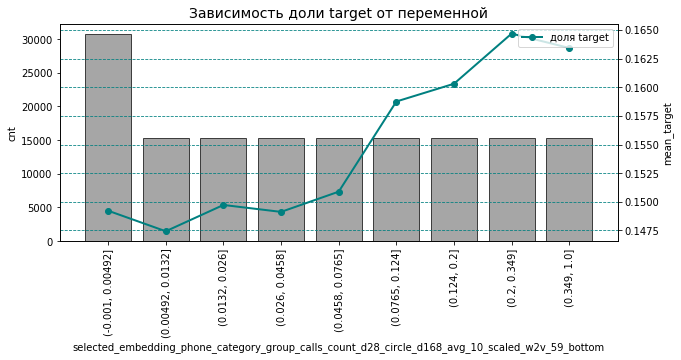

selected_embedding_phone_category_group_calls_count_d28_scaled_w2v_38_bottom


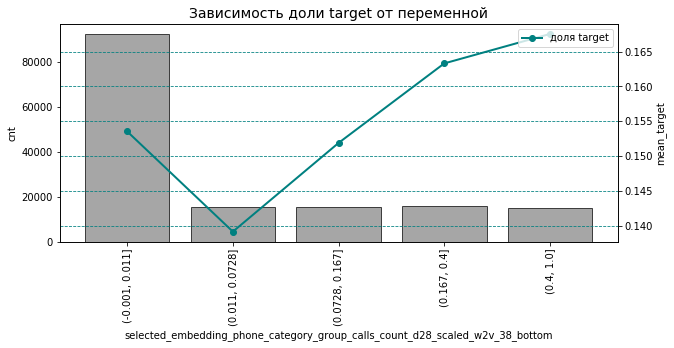

In [139]:
q = 10

for f in features_to_show:
    #f, imp = row['names'], row['gain']
    print(f)
    col = 'bin_' + f
    
    df[col] = pd.qcut(x = df[f], q=q, duplicates='drop').astype('str')
    a = df.groupby(col)['target'].agg([np.size, np.mean]).sort_index()
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(a.index, a['size'], color='gray', alpha=0.7,
           linewidth=1,edgecolor='black',width=0.8)
    ax.set(ylabel='cnt', xlabel=f)
    
    plt.xticks(rotation = 90)
    ax2=ax.twinx()
    ax2.plot(a.index, a['mean'], color='teal', 
             marker='o', lw=2, label='доля target')
    
    ax2.legend(loc='upper right')
    ax2.set(ylabel='mean_target')
    ax2.grid(True,axis='both',color='teal',linestyle='--')
    plt.title('Зависимость доли target от переменной', size=14)
    plt.show()   

### Feature quantiles distribution by months

In [118]:
df['request_ym'] = df.request_date.astype('datetime64[M]')

In [119]:
## get df_q_target
dt_arr = df['request_ym'].unique()
dt_arr.sort(axis=0)

df_q_targ = {}
for target_value in [0]:
    df_feat_q = []
    for i in features_to_show:
        df_list = []
        for j in dt_arr:
            d = df[(df['request_ym'] == j)]# & (df.target == target_value)]
            q_dict = {}
            for q in [0.01, 0.2, 0.5, 0.8, 0.99]:
                q_dict[int(q*100)] = d[i].fillna(-1).quantile(q=q)
            
            mean_ = d[i].mean()
            t = d[i].isnull().value_counts(normalize=True)
            if True in t.index:
                isnull_part = t.loc[True]
            else:
                isnull_part = 0
        
            dict_to_append = {'p_01':q_dict[1],'p_20':q_dict[20],
                              #'p_40':q_dict[40],'p_50':q_dict[50],
                              'p_60':q_dict[50],'p_80':q_dict[80],
                              'p_99':q_dict[99], 'isnull_part': isnull_part, 
                              'mean_': mean_}
            df_list.append(pd.DataFrame.from_dict(dict_to_append, orient='index').sort_index().T)
        
        df_concat = pd.concat(df_list,axis=0)
        df_concat.insert(0, 'date_', dt_arr) 
        df_concat.insert(0, 'feat', i) 
    
        df_feat_q.append(df_concat)
    
    df_q_targ[target_value] = pd.concat(df_feat_q,axis=0)
    df_q_targ[target_value].reset_index(drop=True,inplace=True)

/usr/local/lib64/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/usr/local/lib64/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


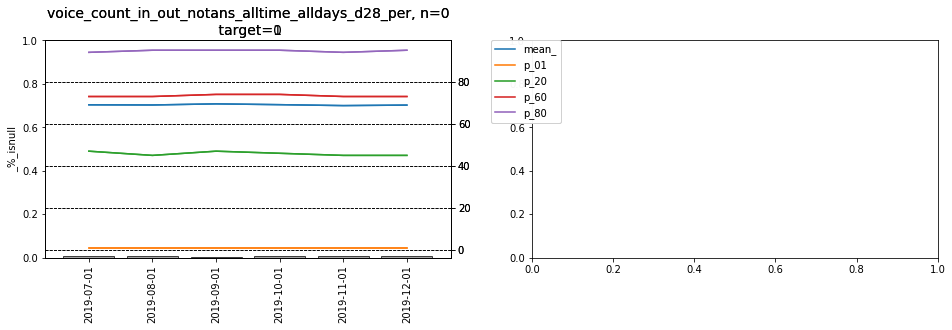

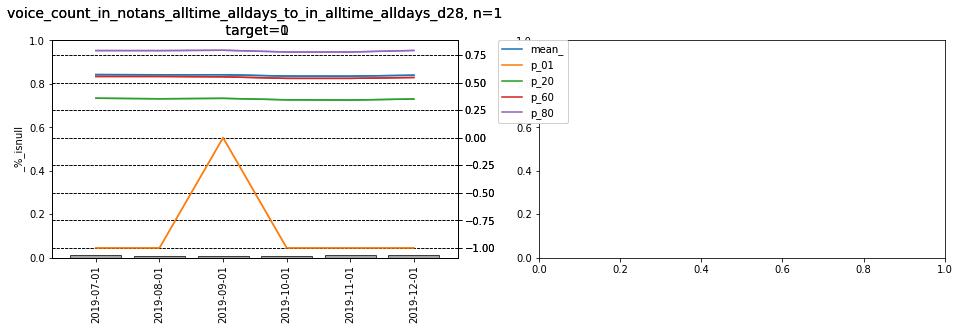

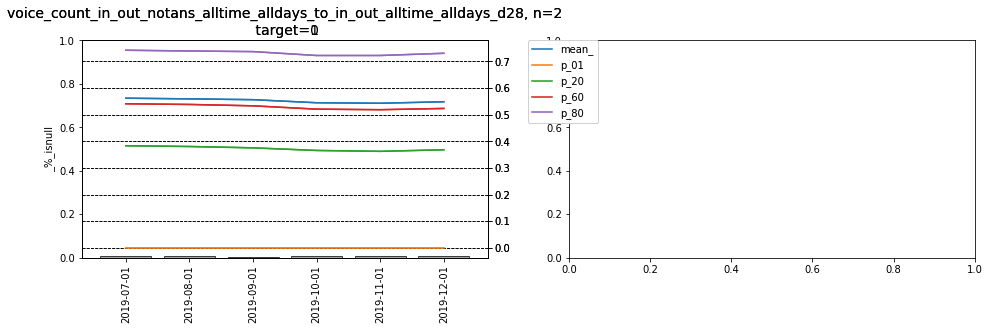

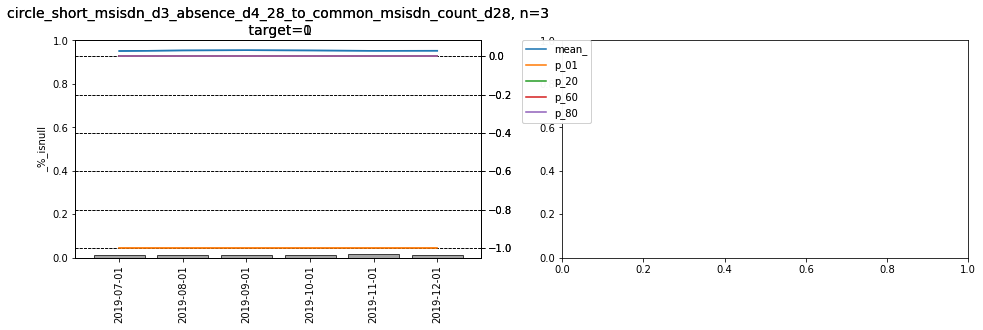

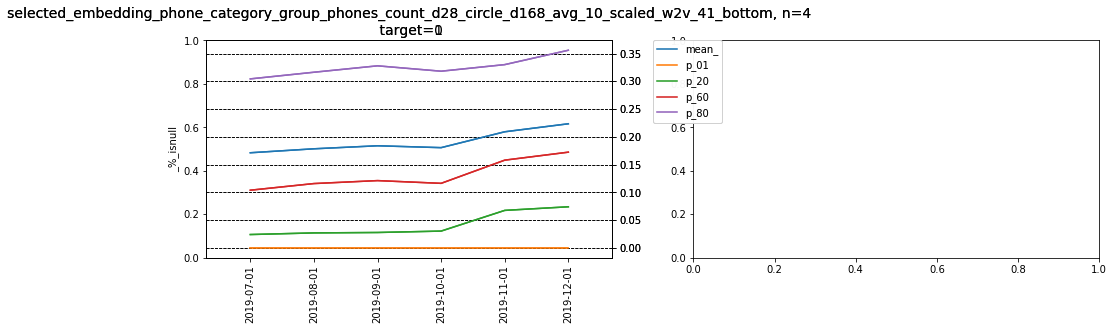

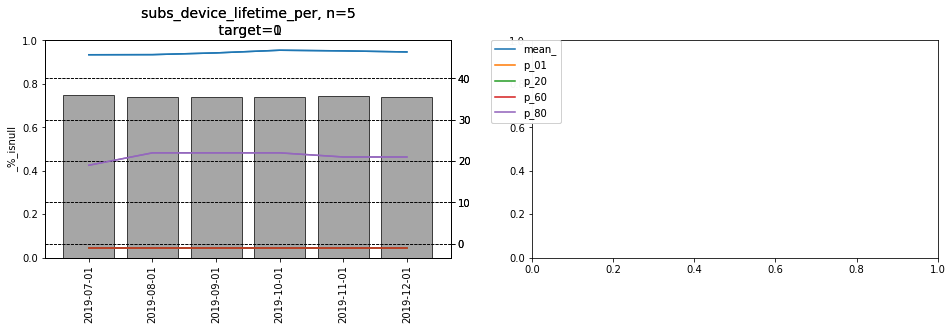

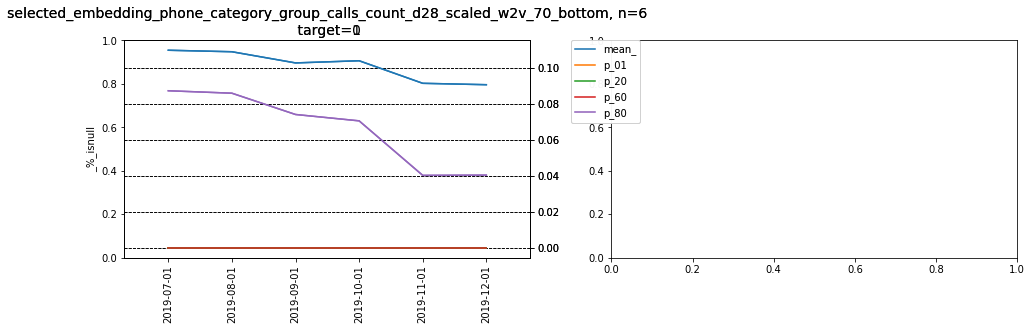

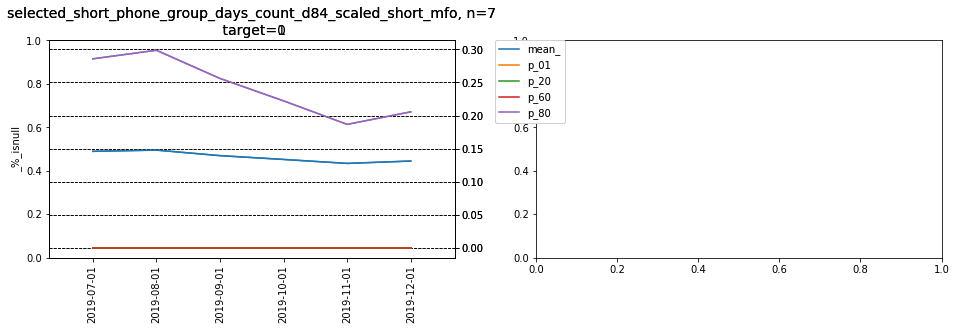

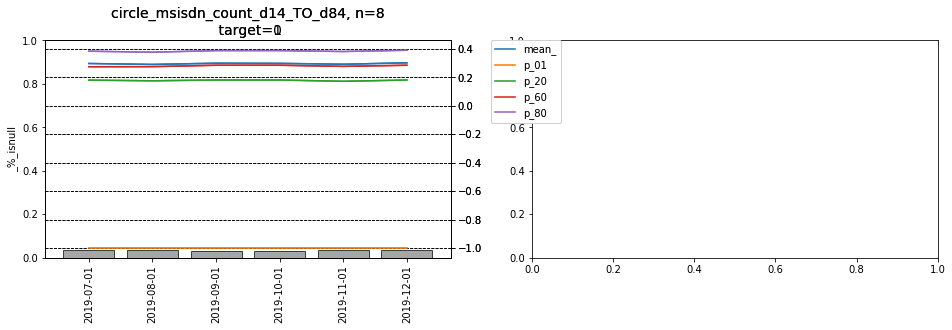

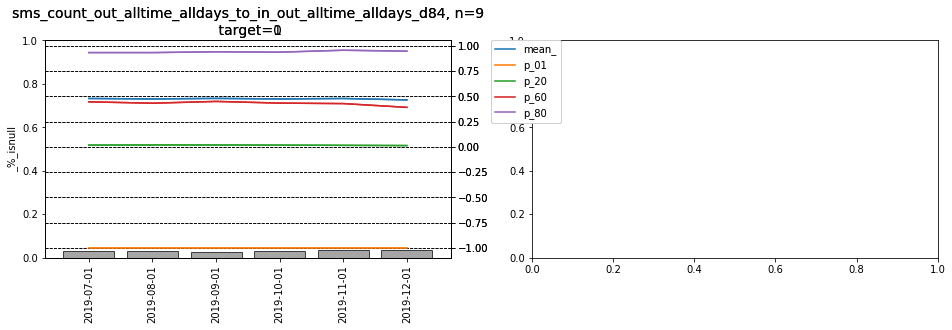

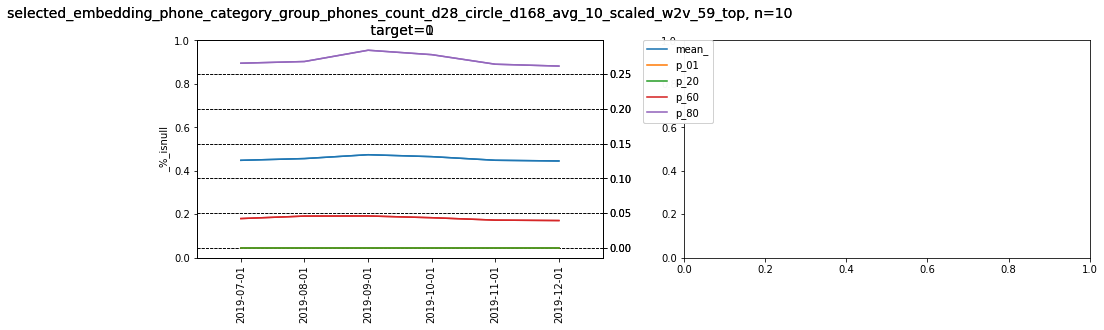

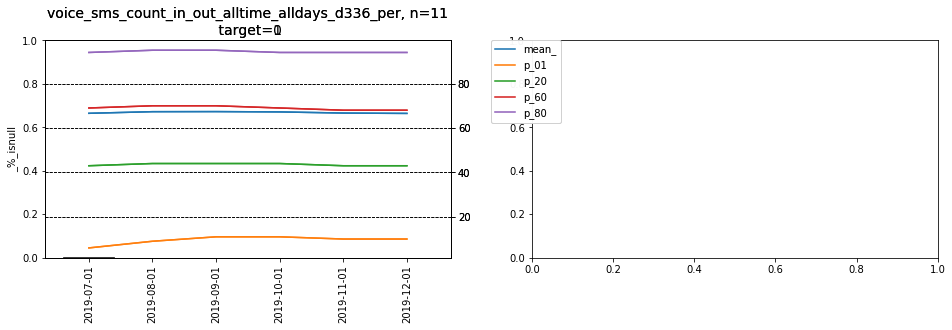

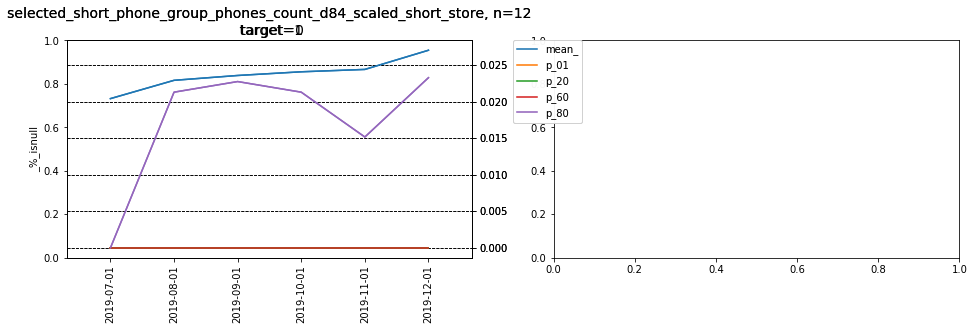

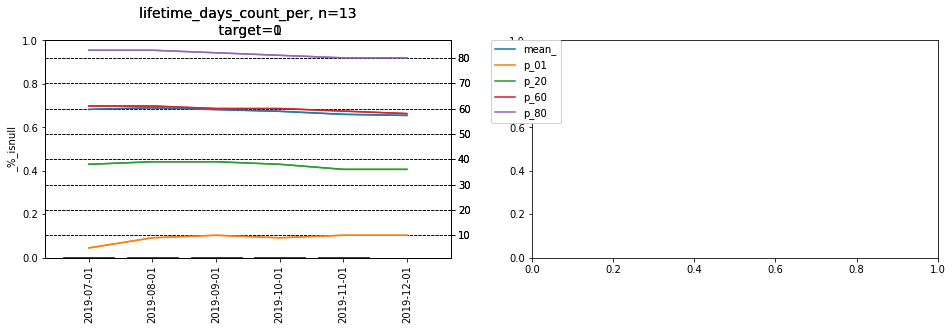

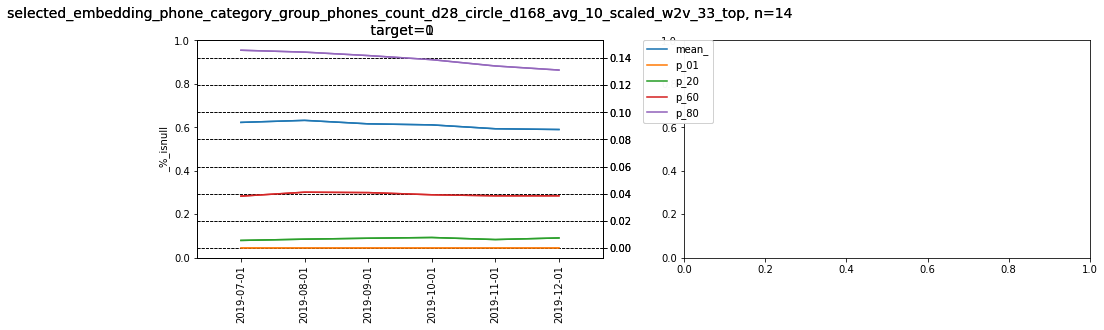

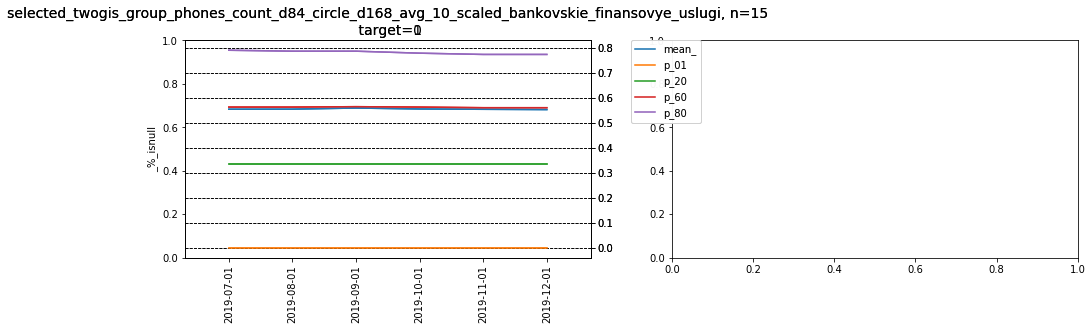

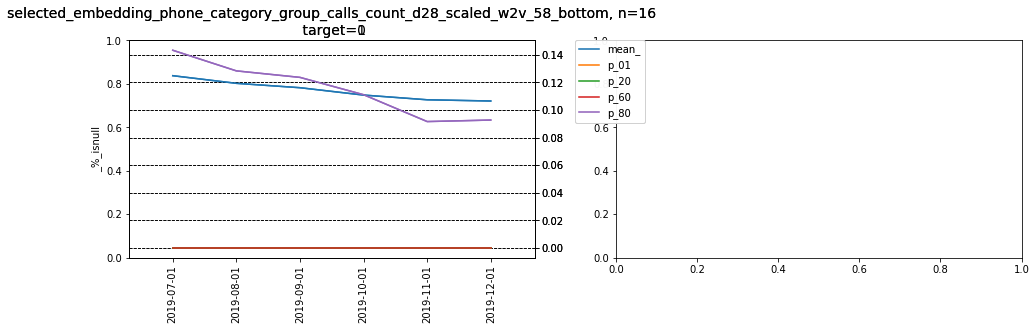

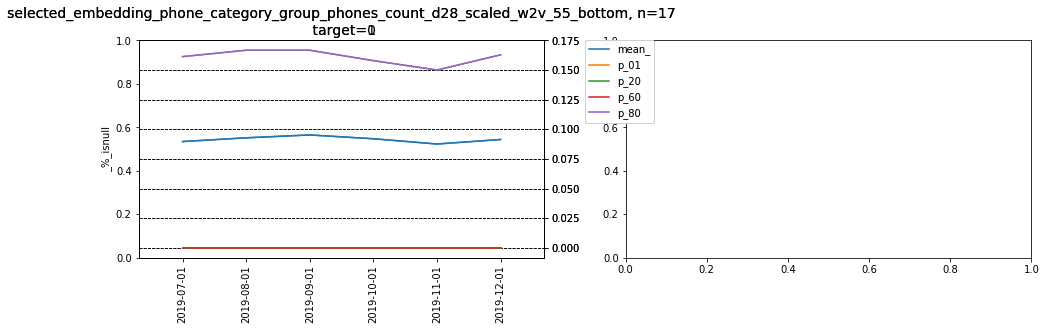

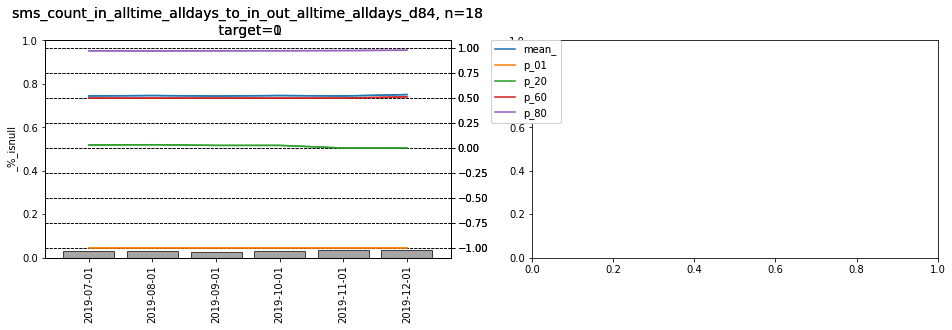

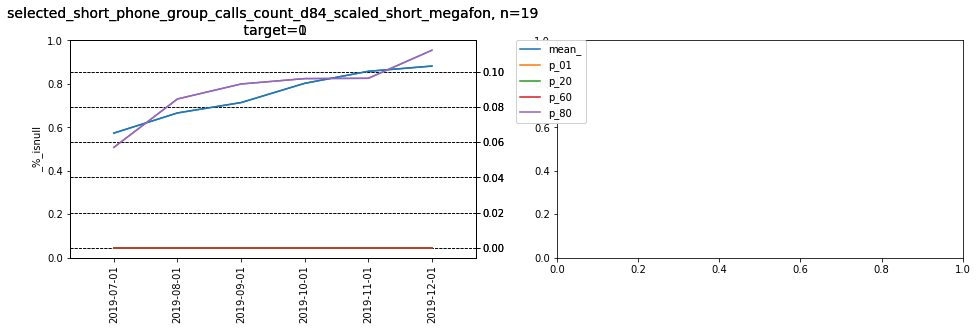

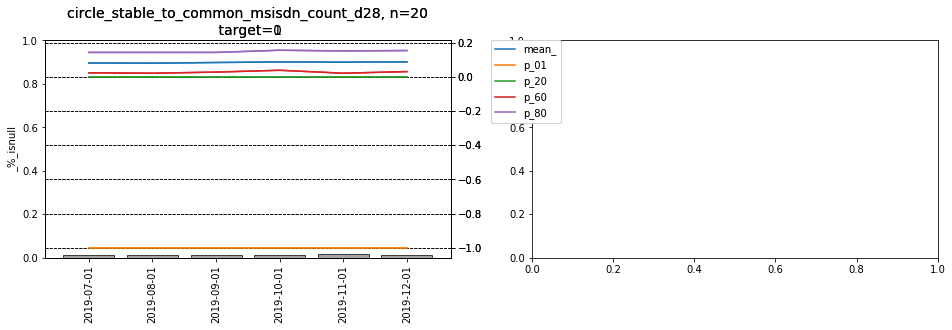

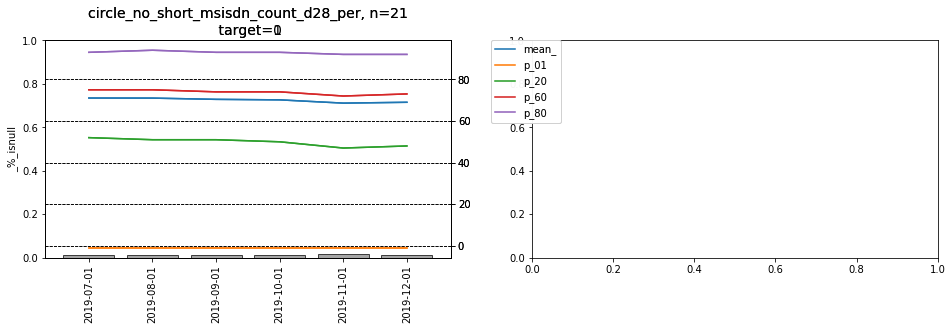

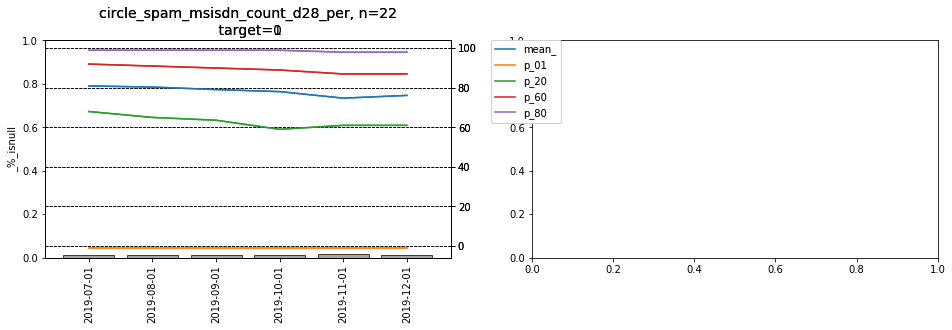

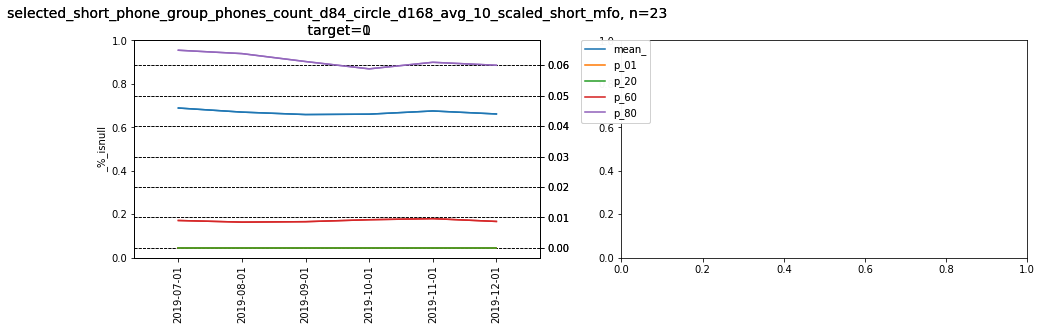

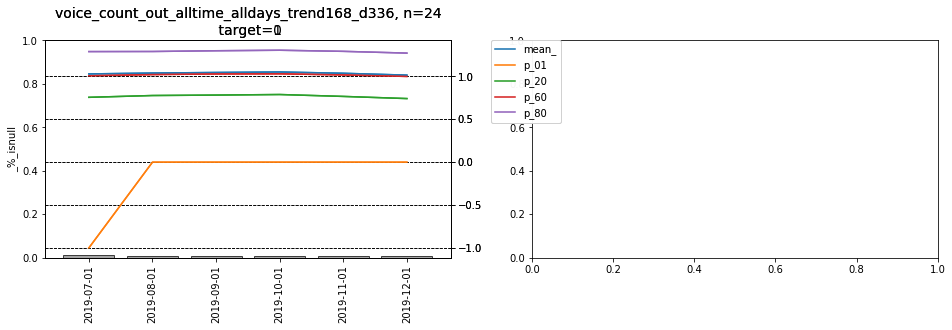

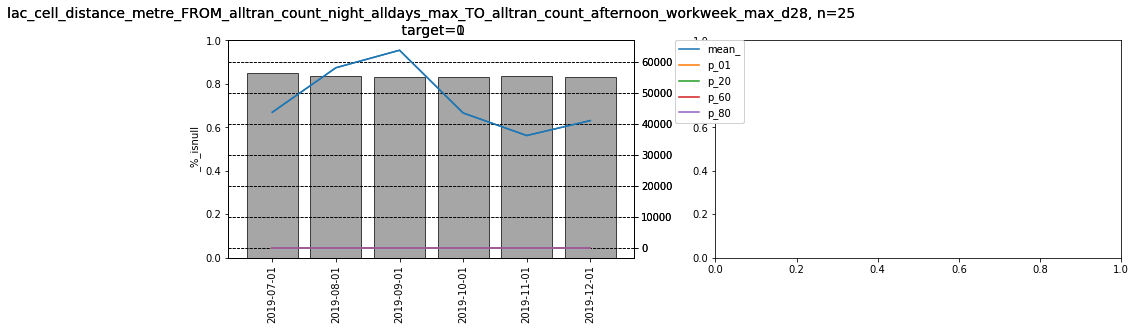

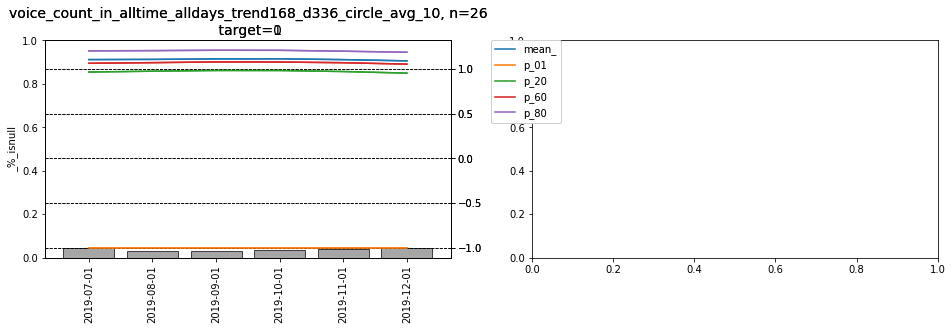

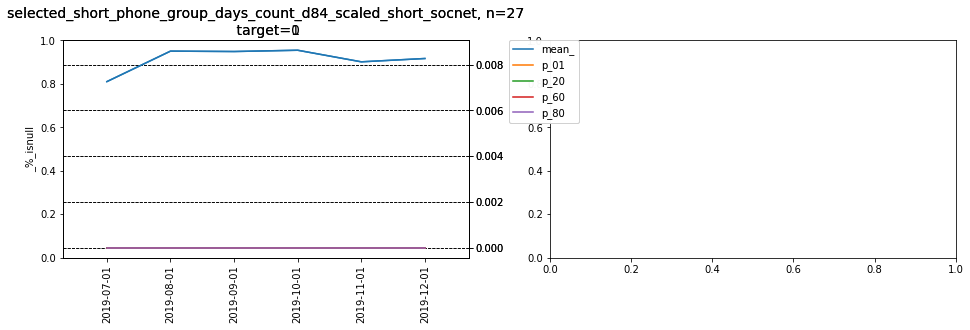

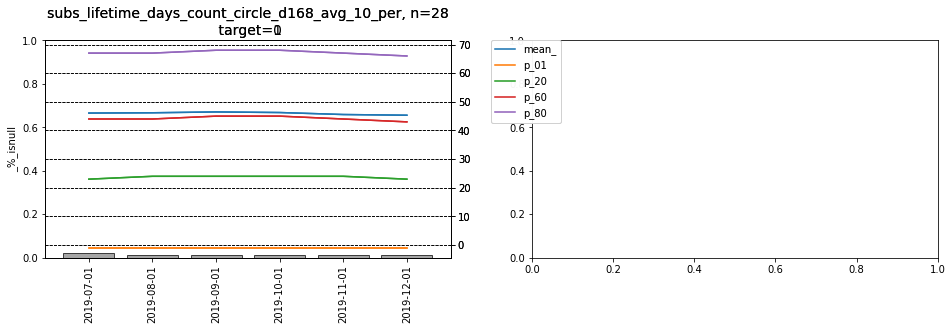

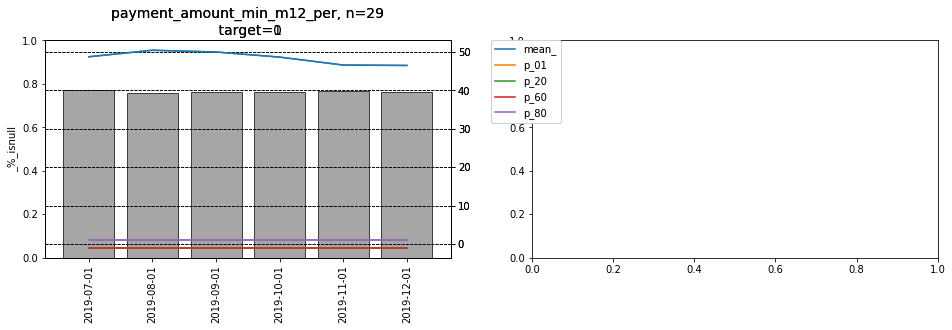

In [120]:
## show
for n, i in enumerate(features_to_show): 
    fig, ax_ = plt.subplots(1, 2, figsize=(16, 4))
    
    ax = ax_[0]
    d = df_q_targ[0][df_q_targ[0]['feat'] == i]
    d.set_index('date_',inplace=True)
    d2 = d[['isnull_part']].copy()
    d.drop(['feat', 'isnull_part', 'p_99'],axis=1,inplace=True)
     
    ax.bar(d2.index.astype('str'), d2['isnull_part'], 
           color='gray', alpha=0.7,
           linewidth=1, edgecolor='black', width=0.8)
    ax.set(ylabel='_%_isnull', ylim=(0,1),)
    ax.tick_params(axis='x', rotation=90)
    
    ax2 = ax.twinx()
    ax2.plot(d.index.astype('str'),d)
    ax2.grid(True,axis='y',color='k',linestyle='--')
    plt.title('{0}, n={1}\n target=0'.format(i,n), size=14)
    
    #ax = ax_[1]
    #d = df_q_targ[1][df_q_targ[1]['feat'] == i]
    #d.set_index('date_',inplace=True)
    #d2 = d[['isnull_part']].copy()
    #d.drop(['feat','isnull_part','p_99'],axis=1,inplace=True)
     
    #ax.bar(d2.index.astype('str'),d2['isnull_part'], 
    #       color='gray',alpha=0.7,
    #       linewidth=1,edgecolor='black',width=0.8)
    #ax.set(ylabel='_%_isnull',ylim=(0,1))
    #ax.tick_params(axis='x', rotation=90)    
    
    ax2=ax.twinx()
    ax2.plot(d.index.astype('str'),d)
    lines = ax2.get_lines()
    leg1=plt.legend(lines,list(d.columns),loc=2,bbox_to_anchor=(1.1, 1),
                    borderaxespad=0.)
    ax2.add_artist(leg1) 
    ax2.grid(True,axis='y',color='k',linestyle='--')
    plt.title('{0}, n={1}\n target=1'.format(i,n), size=14)